In [1]:
%matplotlib inline
import os
from pyurdme import pyurdme
import dolfin
import mshr
import matplotlib.pyplot as plt
import numpy
import pickle
import collections

In [2]:
import os.path
from IPython.display import display, HTML
with open(os.path.join(os.path.dirname(pyurdme.__file__),'data/three.js_templates/js/three.js')) as fd:
    bufa = fd.read()
with open(os.path.join(os.path.dirname(pyurdme.__file__),'data/three.js_templates/js/render.js')) as fd:
    bufb = fd.read()
with open(os.path.join(os.path.dirname(pyurdme.__file__),'data/three.js_templates/js/OrbitControls.js')) as fd:
    bufc = fd.read()
display(HTML('<script>'+bufa+bufc+bufb+'</script>'))

In [3]:
class Membrane(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary
class GbgGradient(pyurdme.URDMEDataFunction):
    def __init__(self, Gbg_mid=5000, Gbg_slope=0.0,mem_vol=1.0):
        """ 1D domain from a to b. """
        pyurdme.URDMEDataFunction.__init__(self, name="GbgGradient")
        self.Gbg_mid = Gbg_mid
        self.Gbg_slope = Gbg_slope  # NM/um
        self.mem_vol = mem_vol
        
    def map(self, x):
        ret = self.Gbg_slope*x[2] + self.Gbg_mid
        return ret/self.mem_vol

In [4]:
# class Cdc42_cycle_3D(pyurdme.URDMEModel):

#     def __init__(self, model_name="Cdc42_3D-Moving_Mesh",Gbg_conc=5000.0, Gbg_pct_slope=0.1,delta1_val=0.00297,delta1_gbg_val=0.00297,delta_neg_val=1.0/30000, end_time=None, mesh=None, msh_filename=None):
#         pyurdme.URDMEModel.__init__(self,model_name)

#         D_membrane = 0.0053   #diffusion on the membrane from PLOS paper
#         D_GDP = 0.0053
#         D_GTP = 0.0053
#         D_bulk = 50.0          #not sure of bulk diffusion const
        
#         # Species
#         Cdc24_m= pyurdme.Species(name="Cdc24_m",  diffusion_constant=D_membrane)
#         Cdc24_c= pyurdme.Species(name="Cdc24_c",  diffusion_constant=D_bulk)
#         Cdc42= pyurdme.Species(name="Cdc42",  diffusion_constant=D_GDP)
#         Cdc42_a= pyurdme.Species(name="Cdc42_a",  diffusion_constant=D_GTP)
#         Bem1_m = pyurdme.Species(name="Bem1_m",  diffusion_constant=D_membrane)
#         Bem1_c = pyurdme.Species(name="Bem1_c",  diffusion_constant=D_bulk)
#         Cla4 = pyurdme.Species(name="Cla4",  diffusion_constant=D_bulk)
#         Cla4_a = pyurdme.Species(name="Cla4_a",  diffusion_constant=D_membrane)
        
#         Cdc42_c = pyurdme.Species(name="Cdc42_c",  diffusion_constant=D_bulk)
#         #Gbg = pyurdme.Species(name="Gbg",  diffusion_constant=D_membrane)
#         self.add_species([Cdc24_m, Cdc24_c, Cdc42, Cdc42_a, Bem1_m, Bem1_c, Cla4, Cla4_a, Cdc42_c])#,Gbg])
        
# #         L = 4*3.14159
# #         NUM_VOXEL = 200
# #         MOLAR=6.02e-01*((L/NUM_VOXEL)**3)
#         #Define Geometry
#         cell_radius = 2.0
#         if mesh is not None:
#             self.mesh = pyurdme.URDMEMesh(mesh=mesh)
#             self.add_subdomain(Membrane(), 2)
#         elif msh_filename is not None:
#             self.mesh = pyurdme.URDMEMesh.read_mesh(msh_filename)
#             boundary_filename = msh_filename[:-4]+'_facet_region.xml'
#             boundaries = dolfin.MeshFunction("size_t", self.mesh, boundary_filename)
#             self.old_style_subdomain=True
#             for i in range(boundaries.size()):
#                 if boundaries[i] != 0:  boundaries[i]=2
#             self.subdomains = collections.OrderedDict()
#             self.subdomains[2] = boundaries
#             #sd = model.get_subdomain_vector()
#         else:
#             sphere = mshr.Sphere(dolfin.Point(0.0, 0.0, 0.0), cell_radius)
#             self.mesh = pyurdme.URDMEMesh(mesh=mshr.generate_mesh(sphere, 15)) #12 works pretty similar, question of correction like in polarisome
#             self.add_subdomain(Membrane(), 2)
        

# #         cell_function = dolfin.CellFunction("size_t",self.mesh)
# #         cell_function.set_all(1)

# #         facet_function = dolfin.FacetFunction("size_t",self.mesh)
# #         facet_function.set_all(0)

# #         membrane = Membrane()
# #         membrane.mark(facet_function,2)

# #         self.add_subdomain(cell_function)
# #         self.add_subdomain(facet_function)
        
#         data = self.get_solver_datastructure()
#         sd = self.get_subdomain_vector()
#         #sys.stdout.write('sd={0}\n'.format(sd))
#         #sys.stdout.flush()
#         volume_vector = data['vol']
        
#         membrane_volume = 0
#         for voxel_index, voxel_coords in enumerate(self.mesh.coordinates()):
#                 if sd[voxel_index] == 2:
#                     membrane_volume = membrane_volume + volume_vector[voxel_index]
                    
#         cytoplasm_volume = 0
#         for voxel_index, voxel_coords in enumerate(self.mesh.coordinates()):
#                 if sd[voxel_index] == 1:
#                     cytoplasm_volume = cytoplasm_volume + volume_vector[voxel_index]
        
# #         SA    = pyurdme.Parameter(name="SA" ,expression=50.265)
# #         V     = pyurdme.Parameter(name="V" ,expression=33.5)
#         k_42d =   pyurdme.Parameter(name="k_42d", expression=1.0)#0.02)
#         k_42a =   pyurdme.Parameter(name="k_42a", expression=0.2)#1e-05*membrane_volume)#*SA)
#         #k_24cm0 = pyurdme.Parameter(name="k_24cm0", expression=0.04*cytoplasm_volume)#*V/SA)
#         k_24cm1 = pyurdme.Parameter(name="k_24cm1", expression=delta1_val)#3.3e-03*cytoplasm_volume)#*V)
#         k_24mc =  pyurdme.Parameter(name="k_24mc", expression=0.35)#1.0)
#         k_B1mc =  pyurdme.Parameter(name="k_B1mc", expression=0.35)#0.01)
#         k_B1cm =  pyurdme.Parameter(name="k_B1cm", expression=0.2667)#1e-05*cytoplasm_volume)#*V)
#         k_Cla4a = pyurdme.Parameter(name="k_Cla4a", expression=0.006)
#         k_Cla4d = pyurdme.Parameter(name="k_Cla4d", expression=0.01)
#         k_24d =   pyurdme.Parameter(name="k_24d", expression=delta_neg_val)#1/3000#membrane_volume#SA
        
#         beta1 = pyurdme.Parameter(name="beta1", expression=0.266)
#         beta2 = pyurdme.Parameter(name="beta2", expression=0.28)
#         beta3 = pyurdme.Parameter(name="beta3", expression=1.0)
#         delta1_gbg = pyurdme.Parameter(name="delta1_gbg", expression=delta1_gbg_val)
#         self.add_parameter([k_42a, k_42d, k_24cm1, k_24mc, k_B1mc, k_B1cm, k_Cla4a, k_Cla4d, k_24d,beta1, beta2, beta3,delta1_gbg])

#         # Add Data Function to model the mating pheromone gradient.
#         #self.add_data_function(GbgGradient(Gbg_mid=Gbg_conc,Gbg_slope=(1000.0/4.0),mem_vol=membrane_volume))
#         self.add_data_function(GbgGradient(Gbg_mid=Gbg_conc,Gbg_slope=Gbg_conc*Gbg_pct_slope/(cell_radius*2.0),mem_vol=membrane_volume))

#         # Reactions
#         # Reactions
#         #Gbg as species
#         #CR0 = pyurdme.Reaction(name="CR0", reactants={Cdc24_c:1,Gbg:1}, products={Cdc24_m:1,Gbg:1}, rate=delta1,restrict_to=2)#propensity_function="0.00297*Cdc24_c*GbgGradient*vol", restrict_to=2)
#         #Gbg as input function
#         #DIFFERENCE WHETHER TO MULTIPLY BY 32 OR NOT
#         CR0 = pyurdme.Reaction(name="CR0", reactants={Cdc24_c:1}, products={Cdc24_m:1}, propensity_function="delta1_gbg*Cdc24_c*GbgGradient*vol", restrict_to=2)
#         CR1 = pyurdme.Reaction(name="CR1", reactants={Cdc24_c:1,Bem1_m:1}, products={Cdc24_m:1,Bem1_m:1},  rate=k_24cm1, restrict_to=2)
#         CR2 = pyurdme.Reaction(name="CR2", reactants={Cdc24_m:1}, products={Cdc24_c:1}, rate=k_24mc, restrict_to=2)
#         CR3 = pyurdme.Reaction(name="CR3", reactants={Cdc24_m:1,Cla4_a:1}, products={Cdc24_c:1,Cla4_a:1}, rate=k_24d, restrict_to=2)
#         CR4 = pyurdme.Reaction(name="CR4", reactants={Cdc24_m:1,Cdc42:1}, products={Cdc24_m:1,Cdc42_a:1}, rate=k_42a, restrict_to=2)
#         CR5 = pyurdme.Reaction(name="CR5", reactants={Cdc42_a:1}, products={Cdc42:1}, rate=k_42d, restrict_to=2)
#         CR6 = pyurdme.Reaction(name="CR6", reactants={Cdc42_a:1,Bem1_c:1}, products={Cdc42_a:1,Bem1_m:1}, rate=k_B1cm, restrict_to=2)
#         CR7 = pyurdme.Reaction(name="CR7", reactants={Bem1_m:1}, products={Bem1_c:1}, rate=k_B1mc, restrict_to=2)
#         CR8 = pyurdme.Reaction(name="CR8", reactants={Cdc42_a:1,Cla4:1}, products={Cdc42_a:1,Cla4_a:1}, rate=k_Cla4a, restrict_to=2)
#         CR9 = pyurdme.Reaction(name="CR9", reactants={Cla4_a:1}, products={Cla4:1}, rate=k_Cla4d, restrict_to=2)
        
#         CR10 = pyurdme.Reaction(name="CR10", reactants={Cdc42_c:1}, products={Cdc42:1}, rate=beta2, restrict_to=2)
#         CR11 = pyurdme.Reaction(name="CR11", reactants={Cdc42:1}, products={Cdc42_c:1}, rate=beta3, restrict_to=2)
#         CR12 = pyurdme.Reaction(name="CR12", reactants={Cdc42_c:1,Cdc24_m:1}, products={Cdc42_a:1,Cdc24_m:1}, rate=beta1, restrict_to=2)
#         self.add_reaction([CR0,CR1,CR2,CR3,CR4,CR5,CR6,CR7,CR8,CR9,CR10,CR11,CR12])
#         #self.add_reaction([CR0,CR1,CR2,CR3,CR4,CR5,CR6,CR7,CR8,CR9])
        
#         self.restrict(species=Cdc24_c,subdomains=[1,2])
#         self.restrict(species=Bem1_c,subdomains=[1,2])
#         self.restrict(species=Cla4,subdomains=[1,2])
#         self.restrict(species=Cdc24_m,subdomains=[2])
#         self.restrict(species=Cdc42,subdomains=[2])
#         self.restrict(species=Cdc42_a,subdomains=[2])
#         self.restrict(species=Bem1_m,subdomains=[2])
#         self.restrict(species=Cla4_a,subdomains=[2])
#         self.restrict(species=Cdc42_c,subdomains=[1,2])
#         #self.restrict(species=Gbg,subdomains=[2])
        
#         try:
#             # Distribute molecules randomly over the mesh according to their initial values
#             self.set_initial_condition_scatter({Cdc42:2700},[2]) #10000  
#             self.set_initial_condition_scatter({Cdc24_c:1000},[1])    #We have 2000 Cdc24, GDI model has 1000
#             self.set_initial_condition_scatter({Bem1_c:3000},[1])
#             self.set_initial_condition_scatter({Cla4:5000},[1]) #5000
#             #self.set_initial_condition_scatter({Cdc42_c:1500},[1])
#             self.set_initial_condition_scatter({Cdc42_a:300},[2])
#             #self.set_initial_condition_scatter({Gbg:5000},[2])
#         except Exception as e:
#             sys.stderr.write("caught exception: {0}".format(e))
        
#         if end_time is None:
#             self.timespan(range(1000))
#         else:
#             #self.timespan([0, end_time])
#             if end_time >= 1.0:
#                 self.timespan(range(end_time))
#             else:
#                 self.timespan(numpy.linspace(0,end_time,10))
#             print "simulating to {0}s".format(end_time)

In [5]:
# fname = 'sphere_result.pkl'
# with open(fname, 'r') as fd:
#     sphere_result = pickle.load(fd)
# fname = 'slight_deform_result.pkl'
# with open(fname, 'r') as fd:
#     slight_deform_result = pickle.load(fd)
# fname = 'projection_result.pkl'
# with open(fname, 'r') as fd:
#     projection_result = pickle.load(fd)

In [6]:
# fname = './geo_experiment_TEST/sphere_result_0.pkl'
# with open(fname, 'r') as fd:
#     sphere_result = pickle.load(fd)

In [7]:
class Cdc42_cycle_3D_ps(pyurdme.URDMEModel):

    def __init__(self, model_name="Cdc42_3D-Moving_Mesh",Gbg_conc=5000.0, Gbg_pct_slope=0.0,delta1_val=0.00297,delta1_gbg_val=0.00297,delta_neg_val=1.0/30000, end_time=None, mesh=None, msh_filename=None,mesh_id=None,rotate=None):
        pyurdme.URDMEModel.__init__(self,model_name)

        D_membrane = 0.0053   #diffusion on the membrane from PLOS paper
        D_GDP = 0.0053
        D_GTP = 0.0053
        D_bulk = 10.0#50.0          #not sure of bulk diffusion const
        
        # Species
        Cdc24_m= pyurdme.Species(name="Cdc24_m",  diffusion_constant=D_membrane)
        Cdc24_c= pyurdme.Species(name="Cdc24_c",  diffusion_constant=D_bulk)
        Cdc42= pyurdme.Species(name="Cdc42",  diffusion_constant=D_GDP)
        Cdc42_a= pyurdme.Species(name="Cdc42_a",  diffusion_constant=D_GTP)
        Bem1_m = pyurdme.Species(name="Bem1_m",  diffusion_constant=D_membrane)
        Bem1_c = pyurdme.Species(name="Bem1_c",  diffusion_constant=D_bulk)
        Cla4 = pyurdme.Species(name="Cla4",  diffusion_constant=D_bulk)
        Cla4_a = pyurdme.Species(name="Cla4_a",  diffusion_constant=D_membrane)
        
        Cdc42_c = pyurdme.Species(name="Cdc42_c",  diffusion_constant=D_bulk)
        #Gbg = pyurdme.Species(name="Gbg",  diffusion_constant=D_membrane)
        self.add_species([Cdc24_m, Cdc24_c, Cdc42, Cdc42_a, Bem1_m, Bem1_c, Cla4, Cla4_a, Cdc42_c])#,Gbg])
        
#         L = 4*3.14159
#         NUM_VOXEL = 200
#         MOLAR=6.02e-01*((L/NUM_VOXEL)**3)
        #Define Geometry
        cell_radius = 2.0
#         if mesh is not None:
#             self.mesh = pyurdme.URDMEMesh(mesh=mesh)
#             self.add_subdomain(Membrane(), 2)
#         elif msh_filename is not None:
#             self.mesh = pyurdme.URDMEMesh.read_mesh(msh_filename)
#             boundary_filename = msh_filename[:-4]+'_facet_region.xml'
#             boundaries = dolfin.MeshFunction("size_t", self.mesh, boundary_filename)
#             self.old_style_subdomain=True
#             for i in range(boundaries.size()):
#                 if boundaries[i] != 0:  boundaries[i]=2
#             self.subdomains = collections.OrderedDict()
#             self.subdomains[2] = boundaries
#             #sd = model.get_subdomain_vector()
#         else:
#             sphere = mshr.Sphere(dolfin.Point(0.0, 0.0, 0.0), cell_radius)
#             self.mesh = pyurdme.URDMEMesh(mesh=mshr.generate_mesh(sphere, 15)) #12 works pretty similar, question of correction like in polarisome
#             self.add_subdomain(Membrane(), 2)
        if mesh_id == 'sphere_gen':
            #ORIG
            sphere = mshr.Sphere(dolfin.Point(0.0, 0.0, 0.0), cell_radius)
            #NEW
            #sphere = mshr.Sphere(dolfin.Point(cell_radius, 0.0, 0.0), cell_radius)
            self.mesh = pyurdme.URDMEMesh(mesh=mshr.generate_mesh(sphere, 15))
            
            cell_function = dolfin.CellFunction("size_t",self.mesh)
            cell_function.set_all(1)

            facet_function = dolfin.FacetFunction("size_t",self.mesh)
            facet_function.set_all(0)

            membrane = Membrane()
            membrane.mark(facet_function,2)

            self.add_subdomain(cell_function)
            self.add_subdomain(facet_function)
        elif mesh_id == 'sphere':
            #USE RESULT SPHERE
            #self.set_initial_condition_from_result_different_mesh(sphere_result)
            self.mesh = sphere_result.model.mesh
            #self.add_subdomain(Membrane(), 2)
            
            cell_function = dolfin.CellFunction("size_t",self.mesh)
            cell_function.set_all(1)

            facet_function = dolfin.FacetFunction("size_t",self.mesh)
            facet_function.set_all(0)

            membrane = Membrane()
            membrane.mark(facet_function,2)

            self.add_subdomain(cell_function)
            self.add_subdomain(facet_function)
        elif mesh_id == 'slight_deform':
            #self.set_initial_condition_from_result_different_mesh(slight_deform_result)
            self.mesh = slight_deform_result.model.mesh
            self.add_subdomain(Membrane(), 2)
        elif mesh_id == 'projection':
            #self.set_initial_condition_from_result_different_mesh(projection_result)
            self.mesh = projection_result.model.mesh
            self.add_subdomain(Membrane(), 2)
        elif mesh_id == 'proj_geo_test':
            self.mesh = proj_geo_test_result.model.mesh
            self.add_subdomain(Membrane(), 2)
        elif mesh_id == 'projection_longer':
            #self.set_initial_condition_from_result_different_mesh(projection_result)
            self.mesh = projection_longer_result.model.mesh
            self.add_subdomain(Membrane(), 2) 
        elif msh_filename is not None:
            self.mesh = pyurdme.URDMEMesh.read_mesh(msh_filename)
            boundary_filename = msh_filename[:-4]+'_facet_region.xml'
            boundaries = dolfin.MeshFunction("size_t", self.mesh, boundary_filename)
            self.old_style_subdomain=True
            for i in range(boundaries.size()):
                if boundaries[i] != 0:  boundaries[i]=2
            self.subdomains = collections.OrderedDict()
            self.subdomains[2] = boundaries
            #sd = model.get_subdomain_vector()
        else:
            raise Exception('Did not set mesh properly {0}'.format(mesh_id))
        
#         if mesh_id is 'sphere':
#             fname = '/stochss-master/app/lib/molnsutil/sphere_result.pkl'
#             with open(fname, 'r') as fd:
#                 sphere_result = pickle.load(fd)
            
#             mesh = sphere_result.model.mesh
#             self.mesh = pyurdme.URDMEMesh(mesh=mesh)
#             self.add_subdomain(Membrane(), 2)
#         elif mesh_id is 'slight_deform':
#             fname = '/stochss-master/app/lib/molnsutil/slight_deform_result.pkl'
#             with open(fname, 'r') as fd:
#                 slight_deform_result = pickle.load(fd)
#             mesh = slight_deform_result.model.mesh
#             self.mesh = pyurdme.URDMEMesh(mesh=mesh)
#             self.add_subdomain(Membrane(), 2)
#         elif mesh_id is 'projection':
#             fname = '/stochss-master/app/lib/molnsutil/projection_result.pkl'
#             with open(fname, 'r') as fd:
#                 projection_result = pickle.load(fd)
#             mesh = projection_result.model.mesh
#             self.mesh = pyurdme.URDMEMesh(mesh=mesh)
#             self.add_subdomain(Membrane(), 2)
        

#         cell_function = dolfin.CellFunction("size_t",self.mesh)
#         cell_function.set_all(1)

#         facet_function = dolfin.FacetFunction("size_t",self.mesh)
#         facet_function.set_all(0)

#         membrane = Membrane()
#         membrane.mark(facet_function,2)

#         self.add_subdomain(cell_function)
#         self.add_subdomain(facet_function)
        
        data = self.get_solver_datastructure()
        sd = self.get_subdomain_vector()
        
        print "# voxels in SD 1 (cytoplasm)",sum(data['sd']==1)
        print "# voxels in SD 2 (membrane)",sum(data['sd']==2)
        
        #sys.stdout.write('sd={0}\n'.format(sd))
        #sys.stdout.flush()
        volume_vector = data['vol']
        
        membrane_volume = 0
        for voxel_index, voxel_coords in enumerate(self.mesh.coordinates()):
                if sd[voxel_index] == 2:
                    membrane_volume = membrane_volume + volume_vector[voxel_index]
                    
        cytoplasm_volume = 0
        for voxel_index, voxel_coords in enumerate(self.mesh.coordinates()):
                if sd[voxel_index] == 1:
                    cytoplasm_volume = cytoplasm_volume + volume_vector[voxel_index]
        
#         SA    = pyurdme.Parameter(name="SA" ,expression=50.265)
#         V     = pyurdme.Parameter(name="V" ,expression=33.5)
        k_42d =   pyurdme.Parameter(name="k_42d", expression=1.0)#0.02)
        k_42a =   pyurdme.Parameter(name="k_42a", expression=0.2)#ORIGINAL: 0.2 #INCREASE: 0.2*100.0 #1e-05*membrane_volume)#*SA)
        #k_24cm0 = pyurdme.Parameter(name="k_24cm0", expression=0.04*cytoplasm_volume)#*V/SA)
        k_24cm1 = pyurdme.Parameter(name="k_24cm1", expression=delta1_val)#ORIGINAL: delta1_val #3.3e-03*cytoplasm_volume)#*V)
        k_24mc =  pyurdme.Parameter(name="k_24mc", expression=0.35) #ORIGINAL: 0.35 #1.0)
        k_B1mc =  pyurdme.Parameter(name="k_B1mc", expression=0.35)#0.01)
        k_B1cm =  pyurdme.Parameter(name="k_B1cm", expression=0.2667)#ORIGINAL: 0.2667 #1e-05*cytoplasm_volume)#*V)
        k_Cla4a = pyurdme.Parameter(name="k_Cla4a", expression=0.006)
        k_Cla4d = pyurdme.Parameter(name="k_Cla4d", expression=0.01)
        k_24d =   pyurdme.Parameter(name="k_24d", expression=delta_neg_val)#1/3000#membrane_volume#SA
        
        beta1 = pyurdme.Parameter(name="beta1", expression=0.266) #ORIGINAL: 0.266  #INCREASE: 0.266*100.0
        beta2 = pyurdme.Parameter(name="beta2", expression=0.28)
        beta3 = pyurdme.Parameter(name="beta3", expression=1.0) #*10.0 #ORIGINAL: 1.0 #INCREASE: 1.0*10.0
        delta1_gbg = pyurdme.Parameter(name="delta1_gbg", expression=delta1_gbg_val)
        self.add_parameter([k_42a, k_42d, k_24cm1, k_24mc, k_B1mc, k_B1cm, k_Cla4a, k_Cla4d, k_24d,beta1, beta2, beta3,delta1_gbg])

        # Add Data Function to model the mating pheromone gradient.
        #self.add_data_function(GbgGradient(Gbg_mid=Gbg_conc,Gbg_slope=(1000.0/4.0),mem_vol=membrane_volume))
        self.add_data_function(GbgGradient(Gbg_mid=Gbg_conc,Gbg_slope=Gbg_conc*Gbg_pct_slope/(cell_radius*2.0),mem_vol=membrane_volume))

        # Reactions
        # Reactions
        #Gbg as species
        #CR0 = pyurdme.Reaction(name="CR0", reactants={Cdc24_c:1,Gbg:1}, products={Cdc24_m:1,Gbg:1}, rate=delta1,restrict_to=2)#propensity_function="0.00297*Cdc24_c*GbgGradient*vol", restrict_to=2)
        #Gbg as input function
        #DIFFERENCE WHETHER TO MULTIPLY BY 32 OR NOT
        CR0 = pyurdme.Reaction(name="CR0", reactants={Cdc24_c:1}, products={Cdc24_m:1}, propensity_function="delta1_gbg*Cdc24_c*GbgGradient*vol", restrict_to=2)
        CR1 = pyurdme.Reaction(name="CR1", reactants={Cdc24_c:1,Bem1_m:1}, products={Cdc24_m:1,Bem1_m:1},  rate=k_24cm1, restrict_to=2)
        CR2 = pyurdme.Reaction(name="CR2", reactants={Cdc24_m:1}, products={Cdc24_c:1}, rate=k_24mc, restrict_to=2)
        CR3 = pyurdme.Reaction(name="CR3", reactants={Cdc24_m:1,Cla4_a:1}, products={Cdc24_c:1,Cla4_a:1}, rate=k_24d, restrict_to=2)
        CR4 = pyurdme.Reaction(name="CR4", reactants={Cdc24_m:1,Cdc42:1}, products={Cdc24_m:1,Cdc42_a:1}, rate=k_42a, restrict_to=2)
        CR5 = pyurdme.Reaction(name="CR5", reactants={Cdc42_a:1}, products={Cdc42:1}, rate=k_42d, restrict_to=2)
        CR6 = pyurdme.Reaction(name="CR6", reactants={Cdc42_a:1,Bem1_c:1}, products={Cdc42_a:1,Bem1_m:1}, rate=k_B1cm, restrict_to=2)
        CR7 = pyurdme.Reaction(name="CR7", reactants={Bem1_m:1}, products={Bem1_c:1}, rate=k_B1mc, restrict_to=2)
        CR8 = pyurdme.Reaction(name="CR8", reactants={Cdc42_a:1,Cla4:1}, products={Cdc42_a:1,Cla4_a:1}, rate=k_Cla4a, restrict_to=2)
        CR9 = pyurdme.Reaction(name="CR9", reactants={Cla4_a:1}, products={Cla4:1}, rate=k_Cla4d, restrict_to=2)
        
        CR10 = pyurdme.Reaction(name="CR10", reactants={Cdc42_c:1}, products={Cdc42:1}, rate=beta2, restrict_to=2)
        CR11 = pyurdme.Reaction(name="CR11", reactants={Cdc42:1}, products={Cdc42_c:1}, rate=beta3, restrict_to=2)
        CR12 = pyurdme.Reaction(name="CR12", reactants={Cdc42_c:1,Cdc24_m:1}, products={Cdc42_a:1,Cdc24_m:1}, rate=beta1, restrict_to=2)
        self.add_reaction([CR0,CR1,CR2,CR3,CR4,CR5,CR6,CR7,CR8,CR9,CR10,CR11,CR12])
        #self.add_reaction([CR0,CR1,CR2,CR3,CR4,CR5,CR6,CR7,CR8,CR9])
        
        self.restrict(species=Cdc24_c,subdomains=[1,2])
        self.restrict(species=Bem1_c,subdomains=[1,2])
        self.restrict(species=Cla4,subdomains=[1,2])
        self.restrict(species=Cdc24_m,subdomains=[2])
        self.restrict(species=Cdc42,subdomains=[2])
        self.restrict(species=Cdc42_a,subdomains=[2])
        self.restrict(species=Bem1_m,subdomains=[2])
        self.restrict(species=Cla4_a,subdomains=[2])
        self.restrict(species=Cdc42_c,subdomains=[1,2])
        #self.restrict(species=Gbg,subdomains=[2])
        
        
        #SCATTER IC
#         try:
            # Distribute molecules randomly over the mesh according to their initial values
        self.set_initial_condition_scatter({Cdc42:2700},[2]) #10000  
        self.set_initial_condition_scatter({Cdc24_c:1000},[1])    #We have 2000 Cdc24, GDI model has 1000
        self.set_initial_condition_scatter({Bem1_c:3000},[1])
        self.set_initial_condition_scatter({Cla4:5000},[1]) #5000
        #self.set_initial_condition_scatter({Cdc42_c:1500},[1])
        self.set_initial_condition_scatter({Cdc42_a:300},[2])
        #self.set_initial_condition_scatter({Gbg:5000},[2])
        
        #IC FROM DIFFERENT MESH
        #self.set_initial_condition_from_result_different_mesh(projection_result)
        
#         if mesh_id == 'sphere':
#             self.set_initial_condition_from_result_different_mesh(sphere_result)#,o_orig=[0,0,0], o_vec=[1,0,0], rotate_rad=numpy.pi)
# #             self.set_initial_condition_scatter({Cdc42:2700},[2]) #10000  
# #             self.set_initial_condition_scatter({Cdc24_c:1000},[1])    #We have 2000 Cdc24, GDI model has 1000
# #             self.set_initial_condition_scatter({Bem1_c:3000},[1])
# #             self.set_initial_condition_scatter({Cla4:5000},[1]) #5000
# #             #self.set_initial_condition_scatter({Cdc42_c:1500},[1])
# #             self.set_initial_condition_scatter({Cdc42_a:300},[2])
# #             #self.set_initial_condition_scatter({Gbg:5000},[2])
#         elif mesh_id == 'slight_deform':
#             self.set_initial_condition_from_result_different_mesh(slight_deform_result)#,o_orig=[0,0,0], o_vec=[1,0,0], rotate_rad=numpy.pi)
# #             self.set_initial_condition_scatter({Cdc42:2956},[2]) #10000  
# #             self.set_initial_condition_scatter({Cdc24_c:1095},[1])    #We have 2000 Cdc24, GDI model has 1000
# #             self.set_initial_condition_scatter({Bem1_c:3284},[1])
# #             self.set_initial_condition_scatter({Cla4:5474},[1]) #5000
# #             #self.set_initial_condition_scatter({Cdc42_c:1500},[1])
# #             self.set_initial_condition_scatter({Cdc42_a:328},[2])
# #             #self.set_initial_condition_scatter({Gbg:5000},[2])
#         elif mesh_id == 'projection':
#             self.set_initial_condition_from_result_different_mesh(projection_result)#,o_orig=[0,0,0], o_vec=[1,0,0], rotate_rad=numpy.pi)
# #             self.set_initial_condition_scatter({Cdc42:3144},[2]) #10000  
# #             self.set_initial_condition_scatter({Cdc24_c:1164},[1])    #We have 2000 Cdc24, GDI model has 1000
# #             self.set_initial_condition_scatter({Bem1_c:3493},[1])
# #             self.set_initial_condition_scatter({Cla4:5822},[1]) #5000
# #             #self.set_initial_condition_scatter({Cdc42_c:1500},[1])
# #             self.set_initial_condition_scatter({Cdc42_a:349},[2])
# #             #self.set_initial_condition_scatter({Gbg:5000},[2])
#         elif mesh_id == 'projection_longer':
#             self.set_initial_condition_from_result_different_mesh(projection_longer_result)#,o_orig=[0,0,0], o_vec=[1,0,0], rotate_rad=numpy.pi)
# #             self.set_initial_condition_scatter({Cdc42:3288},[2]) #10000  
# #             self.set_initial_condition_scatter({Cdc24_c:1218},[1])    #We have 2000 Cdc24, GDI model has 1000
# #             self.set_initial_condition_scatter({Bem1_c:3653},[1])
# #             self.set_initial_condition_scatter({Cla4:6088},[1]) #5000
# #             #self.set_initial_condition_scatter({Cdc42_c:1500},[1])
# #             self.set_initial_condition_scatter({Cdc42_a:365},[2])
# #             #self.set_initial_condition_scatter({Gbg:5000},[2])
        
        
#         except Exception as e:
#             sys.stderr.write("caught exception: {0}".format(e))
#         fname = '/stochss-master/app/lib/molnsutil/sphere_result.pkl'
#         with open(fname, 'r') as fd:
#             sphere_result = pickle.load(fd)
#         self.set_initial_condition_from_result_different_mesh(sphere_result)
#         if mesh_id == 'sphere':
#             #self.set_initial_condition_from_result_different_mesh(sphere_result)
            
#             if rotate is None:
#                 #IC FROM COUPLING
#                 self.set_initial_condition_from_result_different_mesh(sphere_result)            
#             else:
#                 #rotate IC
#                 self.set_initial_condition_from_result_different_mesh(sphere_result, o_orig=[0,0,0], o_vec=[0,0,1], rotate_rad=rotate,verbose=True)
#         elif mesh_id == 'slight_deform':
#             self.set_initial_condition_from_result_different_mesh(slight_deform_result)
#         elif mesh_id == 'projection':
#             #SCATTER
# #             self.set_initial_condition_scatter({Cdc42:2700},[2]) #10000  
# #             self.set_initial_condition_scatter({Cdc24_c:1000},[1])    #We have 2000 Cdc24, GDI model has 1000
# #             self.set_initial_condition_scatter({Bem1_c:3000},[1])
# #             self.set_initial_condition_scatter({Cla4:5000},[1]) #5000
# #             #self.set_initial_condition_scatter({Cdc42_c:1500},[1])
# #             self.set_initial_condition_scatter({Cdc42_a:300},[2])
# #             #self.set_initial_condition_scatter({Gbg:5000},[2])
            
#             if rotate is None:
#                 #IC FROM COUPLING
#                 self.set_initial_condition_from_result_different_mesh(projection_result)            
#             else:
#                 #rotate IC
#                 self.set_initial_condition_from_result_different_mesh(projection_result, o_orig=[0,0,0], o_vec=[0,0,1], rotate_rad=rotate)
#         elif mesh_id == 'proj_geo_test':
#             self.set_initial_condition_from_result_different_mesh(proj_geo_test_result)
#         elif mesh_id == 'projection_longer':
#             self.set_initial_condition_from_result_different_mesh(projection_longer_result)
        
        
        if end_time is None:
            self.timespan(range(1000))
        else:
            #self.timespan([0, end_time])
            if end_time >= 1.0:
                self.timespan(range(end_time))
            else:
                self.timespan(numpy.linspace(0,end_time,10))
            print "simulating to {0}s".format(end_time)

In [8]:
# fname = './geo_experiment_1/sphere_result_9.pkl'
# with open(fname, 'r') as fd:
#     sphere_result = pickle.load(fd)
# fname = './geo_experiment_1/slight_deform_result_9.pkl'
# with open(fname, 'r') as fd:
#     slight_deform_result = pickle.load(fd)
# fname = './geo_experiment_1/projection_result_9.pkl'
# with open(fname, 'r') as fd:
#     projection_result = pickle.load(fd)
# fname = './geo_experiment_1/projection_longer_result_9.pkl'
# with open(fname, 'r') as fd:
#     projection_longer_result = pickle.load(fd)

In [9]:
#model1 = Cdc42_cycle_3D_ps(mesh_id='sphere',end_time=0.001)

In [10]:
#result1 = model1.run()

In [11]:
#result1.display('Cdc42_a',0,camera=[-2.0,0.0,0.0])

In [12]:
#model2 = Cdc42_cycle_3D_ps(mesh_id='sphere',end_time=0.001, rotate=numpy.pi)

In [13]:
#result2 = model2.run()

In [14]:
#result2.display('Cdc42_a',0,camera=[2.0,0.0,0.0])

In [15]:
#model = Cdc42_cycle_3D_ps(delta_neg_val=0.0/30000,msh_filename = 'pill_long_fat_result_0.msh')#msh_filename = 'pill_large.msh')#mesh_id='projection')  #Gbg_conc in units of molecules of Gbg on membrane, 5000 at half activation
model = Cdc42_cycle_3D_ps(delta_neg_val=0.0,mesh_id = 'sphere_gen',end_time=1000)#msh_filename = 'pill_large.msh')#mesh_id='projection')  #Gbg_conc in units of molecules of Gbg on membrane, 5000 at half activation
model.sd_initialized

# voxels in SD 1 (cytoplasm) 953
# voxels in SD 2 (membrane) 567
simulating to 1000s


True

In [16]:
x = model.mesh.coordinates()

In [20]:
x.shape

(1520, 3)

In [19]:
model.sd.shape

(1520,)

In [25]:
with open("cdc42_mesh_output.txt","w") as f:
    for i in range(len(model.sd)):
        f.write("create_atoms {0} single {1} {2} {3}\n".format(int(model.sd[i]), x[i,0], x[i,1], x[i,2]))

In [21]:
numpy.savetxt('mesh1_coor.dat', x)

In [17]:
f = open("mesh1_coor.dat", "w")
f.write(x)
f.close() 

In [18]:
% time result = model.run()

CPU times: user 3.11 s, sys: 30.5 ms, total: 3.14 s
Wall time: 4min 17s


In [19]:
result.display('Cdc42_a',999)#,camera=[-5,5,5])

## TAU-MU STOP HERE :)

In [19]:
# fname = './geo_experiment_TEST/projection_longer_result_IC_9_neg_3.pkl'
# with open(fname, 'w+') as fd:
#     pickle.dump(result, fd)

In [20]:
# fname = 'projection_longer_result_paper.pkl'
# with open(fname, 'w+') as fd:
#     pickle.dump(result, fd)

In [21]:
# fname = 'proj_geo_test.pkl'
# with open(fname,'r') as fd:
#     proj_geo_test_result = pickle.load(fd)

In [22]:
# fname = 'proj_geo_test.pkl'
# with open(fname,'w+') as fd:
#     pickle.dump(result,fd)

In [20]:
B_vals_plot = result.get_species('Cdc42_a', concentration=False)
B_vs_time = numpy.sum(B_vals_plot,axis=1)

In [21]:
B_vals_plot_2 = result.get_species('Cdc42', concentration=False)
B_vs_time_2 = numpy.sum(B_vals_plot_2,axis=1)

In [22]:
B_vals_plot_3 = result.get_species('Cdc42_c', concentration=False)
B_vs_time_3 = numpy.sum(B_vals_plot_3,axis=1)

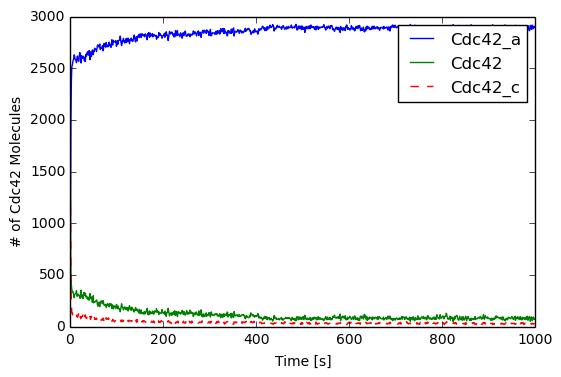

In [23]:
plt.plot(B_vs_time,label='Cdc42_a')
plt.plot(B_vs_time_2,label='Cdc42')
plt.plot(B_vs_time_3,'r--',label='Cdc42_c')
plt.legend(loc=1)
plt.xlabel('Time [s]')
plt.ylabel('# of Cdc42 Molecules')
#plt.title('Cdc42 vs Time')
plt.savefig('Cdc42_vs_time.pdf', format='pdf', dpi=1000)

In [27]:
sd = model.get_subdomain_vector()
membrane_voxels = numpy.where(sd==2)[0]
sum_over_time_0 = result.get_species('Cdc42_a', concentration=False)
sum_over_time = numpy.sum(sum_over_time_0[:,membrane_voxels],axis=0)
x_center = model.mesh.coordinates()[membrane_voxels,0]
y_center = model.mesh.coordinates()[membrane_voxels,1]
z_center = model.mesh.coordinates()[membrane_voxels,2]

In [28]:
#cyto_voxels = numpy.where(sd)[0]
sum_over_time_0 = result.get_species('Cdc42_c', concentration=False)
#sum_over_time = numpy.sum(sum_over_time_0[:,cyto_voxels],axis=0)
tpt = 200
sum_over_time_1 = numpy.array(sum_over_time_0[tpt,:])
#sum_over_time_1 = numpy.sum(sum_over_time_0[:,:],axis=0)


cyto_voxels_greater_0 = numpy.where(sum_over_time_1)[0]
sum_over_time = sum_over_time_1[cyto_voxels_greater_0]
                                    
x_center = model.mesh.coordinates()[cyto_voxels_greater_0,0]
y_center = model.mesh.coordinates()[cyto_voxels_greater_0,1]
z_center = model.mesh.coordinates()[cyto_voxels_greater_0,2]

In [29]:
test = numpy.array([6,1,2,3,4,5])
test[numpy.where(test>3)]

array([6, 4, 5])

In [30]:
#sum_over_time

In [31]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.cm as cm

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# sp = ax.scatter(x_center,y_center,z_center, c=sum_over_time)
# ax.view_init(elev=10,azim=110)
# #ax.view_init(elev=100,azim=0)
# plt.xlabel('x')
# plt.ylabel('y')
# #plt.zlabel('z')
# plt.colorbar(sp)
# plt.savefig('Altschuler_heat_map_3D.png',dpi=500)

In [32]:
# #This currently uses the voxels listed in voxels_center (which are the top "X" percent of particle counts in B_vals) and checks
# #an area around the center equivalent to roughly 10% of the membrane surface area and calculates a percentage of membrane particles
# #found for each one
# def percent_polarized_v_time_short(result):
#     import numpy
#     import time
    
#     #origin = [max(model.mesh.coordinates()[:,0])-2.0,0.0,0.0]
#     #origin = [0.0,0.0,0.0]
    
#     tic = time.time()
#     model = result.model
#     data = model.get_solver_datastructure()
#     sd = model.get_subdomain_vector()
#     mesh_coordinates = model.mesh.coordinates()

#     origin = [max(model.mesh.coordinates()[:,0])-2.0,0.0,0.0]
    
#     vol = data['vol']
#     membrane_voxels = numpy.where(sd==2)[0]
    
# #     K = data['K']
# #     #print numpy.shape(K),len(membrane_voxels)
# #     mem_neighbor_list = []#numpy.zeros((len(membrane_voxels)))
# #     for i,m in enumerate(membrane_voxels):
# #         mem_neighbor_list.append(numpy.where(K[m].toarray()[0]!=0)[0])
    
#     #print mem_neighbor_list
#     #print neighbor_list
#     #for voxel_index, voxel_coords in enumerate(model.mesh.coordinates()):
#     #    if sd[voxel_index] == 2:
#     #        membrane_voxels.append(voxel_index)
    
#     B_vals_list = []
#     B_vals_to_check_list = []
#     min_to_check_list = []
#     voxels_center_list = []
#     B_vals_sort_list = []
    
#     B_vals_plot = result.get_species('Cdc42_a', concentration=False)
#     B_vs_time = numpy.sum(B_vals_plot,axis=1)
    
#     t_list = [0,100,200,500,999]
#     for n,t in enumerate(t_list):
#     #n=-1
#     #t=max(model.tspan)
#         B_val_temp = B_vals_plot[t,:]#result.get_species('B', timepoints=n, concentration=False)

#         B_vals_list.append(B_val_temp)
#         B_vals_sort_list.append(sorted(B_vals_list[n]))

#     for idx,val in enumerate(B_vals_sort_list):
#     #idx = 0
#         B_vals_to_check_list.append(B_vals_sort_list[idx][int(len(B_vals_sort_list[idx]) * .98) : int(len(B_vals_sort_list[idx]) * 1.0)]) 
#         min_to_check_list.append(min(B_vals_to_check_list[idx]))
#         voxels_center_list.append(map(int,[i for i, j in enumerate(B_vals_list[idx]) if j >= min_to_check_list[idx] and sd[i] == 2])) 
    
#     #print voxels_center_list, len(membrane_voxels)
        
#     percent_polarized_max_list = []
#     index_polarized_max_list = []
#     theta_center_list = []
#     phi_center_list = []
#     theta_projection_xz_list =[]
#     theta_projection_yz_list = []
#     for n,t in enumerate(t_list):
        
#         max_part_count = max(B_vals_list[n])
#         indx_max_part_count = numpy.argmax(B_vals_list[n])
        
#         B_check = sum(B_vals_list[n])
#         particle_sum_list = []
#         percentage_around_center_list = []
#         voxel_counter_list = []
#         voxels_visited_list = []
#         if B_check==0:
#             percentage_around_center = 0
#             percentage_around_center_list.append([percentage_around_center])
#         else:
#             j = 0
#             for v in voxels_center_list[n]:
#                 particle_sum = 0.0
#                 percentage_around_center = 0.0
#                 voxel_counter = 0.0
#                 voxels_visited = []
#                 x_center, y_center, z_center = mesh_coordinates[v,:]
#                 dist_center = numpy.sqrt((x_center-origin[0])**2 + y_center**2 + z_center**2)
#                 for i in membrane_voxels:
#                     try:
#                         x_check, y_check, z_check = mesh_coordinates[i,:]
#                     except ValueError as e:
#                         print mesh_coordinates[i,:]
#                         print i
#                         print e
#                         raise e
#                     dist_check = numpy.sqrt((x_check-origin[0])**2 + y_check**2 + z_check**2)
#                     angle_between = numpy.arccos(numpy.dot([x_center-origin[0],y_center,z_center],[x_check-origin[0],y_check,z_check])/(dist_check*dist_center) - 1e-8)
#                     if angle_between <= numpy.arcsin(.6):
#                         particle_sum = particle_sum + B_vals_list[n][i]
#                         voxel_counter = voxel_counter + 1
#                         voxels_visited.append(i)

#                 particle_sum_list.append(particle_sum)
#                 voxel_counter_list.append(voxel_counter)
#                 voxels_visited_list.append([voxels_visited,v])

#                 percentage_around_center = particle_sum_list[j]/B_check*100 

#                 percentage_around_center_list.append([percentage_around_center,v])
#                 j = j + 1

#         percent_polarized_max_list.append(max(percentage_around_center_list)[0])
#         index_polarized_max_list.append(max(percentage_around_center_list)[1])
#         #percent_polarized_max_list.append(max_part_count)
#         #index_polarized_max_list.append(indx_max_part_count)
#         x_center = model.mesh.coordinates()[index_polarized_max_list[n],0]
#         y_center = model.mesh.coordinates()[index_polarized_max_list[n],1]
#         z_center = model.mesh.coordinates()[index_polarized_max_list[n],2]
#         dist_center = numpy.sqrt((x_center-origin[0])**2 + y_center**2 + z_center**2)
#         #[x_check_1,y_check_1,z_check_1] = [0.0-origin[0],0.0,1.0]
#         [x_check_1,y_check_1,z_check_1] = [0.0,0.0,1.0]
#         dist_check_1 = numpy.sqrt(x_check_1**2 + y_check_1**2 + z_check_1**2)
#         #[x_check_2,y_check_2,z_check_2] = [1.0-origin[0],0.0,0.0]
#         [x_check_2,y_check_2,z_check_2] = [1.0,0.0,0.0]
#         dist_check_2 = numpy.sqrt(x_check_2**2 + y_check_2**2 + z_check_2**2)
#         dist_projection_xz = numpy.sqrt(x_center*x_center + z_center*z_center)
#         dist_projection_yz = numpy.sqrt(y_center*y_center + z_center*z_center)
#         #theta_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],y_center,z_center],[0.0-origin[0],0.0,1.0])/(dist_check_1*dist_center)-1e-8))
#         #phi_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],0.0,z_center],[1.0-origin[0],0.0,0.0])/(dist_check_2*dist_center)-1e-8))
#         theta_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],y_center,z_center],[0.0,0.0,1.0])/(dist_check_1*dist_center)-1e-8))
#         phi_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],0.0,z_center],[1.0,0.0,0.0])/(dist_check_2*dist_center)-1e-8))
# #         dist_check = numpy.sqrt((x_check-origin[0])**2 + y_check**2 + z_check**2)
# #         dist_projection_xz = numpy.sqrt(x_center*x_center + z_center*z_center)
# #         dist_projection_yz = numpy.sqrt(y_center*y_center + z_center*z_center)
# #         theta_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],y_center,z_center],[0.0-origin[0],0.0,1.0])/(dist_check*dist_center)-1e-8))
# #         phi_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],0.0,z_center],[1.0-origin[0],0.0,0.0])/(dist_check*dist_center)-1e-8))

#     #print percentage_around_center_list,percent_polarized_max_list,index_polarized_max_list,x_center,y_center,z_center
#     return [theta_center_list,phi_center_list]

In [33]:
#This currently uses the voxels listed in voxels_center (which are the top "X" percent of particle counts in B_vals) and checks
#an area around the center equivalent to roughly 10% of the membrane surface area and calculates a percentage of membrane particles
#found for each one
def percent_polarized_v_time_short(result):
    import numpy
    import time
    
    #origin = [max(model.mesh.coordinates()[:,0])-2.0,0.0,0.0]
    #origin = [0.0,0.0,0.0]
    
    tic = time.time()
    model = result.model
    data = model.get_solver_datastructure()
    sd = model.get_subdomain_vector()
    mesh_coordinates = model.mesh.coordinates()

    origin = [max(model.mesh.coordinates()[:,0])-2.0,0.0,0.0]
    
    vol = data['vol']
    membrane_voxels = numpy.where(sd==2)[0]
    
    #for voxel_index, voxel_coords in enumerate(model.mesh.coordinates()):
    #    if sd[voxel_index] == 2:
    #        membrane_voxels.append(voxel_index)
    
    B_vals_list = []
    B_vals_to_check_list = []
    min_to_check_list = []
    voxels_center_list = []
    B_vals_sort_list = []
    
    B_vals_plot = result.get_species('Cdc42_a', concentration=False)
    B_vs_time = numpy.sum(B_vals_plot,axis=1)
    
    #t_list = [-1]
    t_list = [0,1,2,3,4,100,200,499]#500,995,996,997,998,999]
    #t_list = model.tspan
    for n,t in enumerate(t_list):
    #n=-1
    #t=max(model.tspan)
        B_val_temp = B_vals_plot[t,:]#result.get_species('B', timepoints=n, concentration=False)

        B_vals_list.append(B_val_temp)
        B_vals_sort_list.append(sorted(B_vals_list[n]))

    for idx,val in enumerate(B_vals_sort_list):
    #idx = 0
        B_vals_to_check_list.append(B_vals_sort_list[idx][int(len(B_vals_sort_list[idx]) * .98) : int(len(B_vals_sort_list[idx]) * 1.0)]) 
        min_to_check_list.append(min(B_vals_to_check_list[idx]))
        voxels_center_list.append(map(int,[i for i, j in enumerate(B_vals_list[idx]) if j >= min_to_check_list[idx] and sd[i] == 2])) 
    
    percent_polarized_max_list = []
    index_polarized_max_list = []
    theta_center_list = []
    phi_center_list = []
    theta_projection_xz_list =[]
    theta_projection_yz_list = []
    for n,t in enumerate(t_list):
        
        max_part_count = max(B_vals_list[n])
        indx_max_part_count = numpy.argmax(B_vals_list[n])
        
        B_check = sum(B_vals_list[n])
        particle_sum_list = []
        percentage_around_center_list = []
        voxel_counter_list = []
        voxels_visited_list = []
        if B_check==0:
            percentage_around_center = 0
            percentage_around_center_list.append([percentage_around_center,0.0])
        else:
            j = 0
            for v in voxels_center_list[n]:
                particle_sum = 0.0
                percentage_around_center = 0.0
                voxel_counter = 0.0
                voxels_visited = []
                x_center, y_center, z_center = mesh_coordinates[v,:]
                dist_center = numpy.sqrt((x_center-origin[0])**2 + y_center**2 + z_center**2)
                for i in membrane_voxels:
                    try:
                        x_check, y_check, z_check = mesh_coordinates[i,:]
                    except ValueError as e:
                        print mesh_coordinates[i,:]
                        print i
                        print e
                        raise e
                    dist_check = numpy.sqrt((x_check-origin[0])**2 + y_check**2 + z_check**2)
                    angle_between = numpy.arccos(numpy.dot([x_center-origin[0],y_center,z_center],[x_check-origin[0],y_check,z_check])/(dist_check*dist_center) - 1e-8)
                    if angle_between <= numpy.arcsin(.6):
                        particle_sum = particle_sum + B_vals_list[n][i]
                        voxel_counter = voxel_counter + 1
                        voxels_visited.append(i)

                particle_sum_list.append(particle_sum)
                voxel_counter_list.append(voxel_counter)
                voxels_visited_list.append([voxels_visited,v])

                percentage_around_center = particle_sum_list[j]/B_check*100 

                percentage_around_center_list.append([percentage_around_center,v])
                j = j + 1

        percent_polarized_max_list.append(max(percentage_around_center_list)[0])
        index_polarized_max_list.append(max(percentage_around_center_list)[1])
        #percent_polarized_max_list.append(max_part_count)
        #index_polarized_max_list.append(indx_max_part_count)
        x_center = model.mesh.coordinates()[index_polarized_max_list[n],0]
        y_center = model.mesh.coordinates()[index_polarized_max_list[n],1]
        z_center = model.mesh.coordinates()[index_polarized_max_list[n],2]
        dist_center = numpy.sqrt((x_center-origin[0])**2 + y_center**2 + z_center**2)
        #[x_check_1,y_check_1,z_check_1] = [0.0-origin[0],0.0,1.0]
        [x_check_1,y_check_1,z_check_1] = [0.0,0.0,1.0]
        dist_check_1 = numpy.sqrt(x_check_1**2 + y_check_1**2 + z_check_1**2)
        #[x_check_2,y_check_2,z_check_2] = [1.0-origin[0],0.0,0.0]
        [x_check_2,y_check_2,z_check_2] = [1.0,0.0,0.0]
        dist_check_2 = numpy.sqrt(x_check_2**2 + y_check_2**2 + z_check_2**2)
        dist_phi = numpy.sqrt((x_center-origin[0])**2 + y_center**2)
        dist_projection_xz = numpy.sqrt(x_center*x_center + z_center*z_center)
        dist_projection_yz = numpy.sqrt(y_center*y_center + z_center*z_center)
#         theta_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],y_center,z_center],[0.0-origin[0],0.0,1.0])/(dist_check_1*dist_center)-1e-8))
#         phi_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],0.0,z_center],[1.0-origin[0],0.0,0.0])/(dist_check_2*dist_center)-1e-8))
        theta_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],y_center,z_center],[0.0,0.0,1.0])/(dist_check_1*dist_center)))#-1e-8))
        #phi_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],0.0,z_center],[1.0,0.0,0.0])/(dist_check_2*dist_center)-1e-8))
        phi = numpy.arccos(numpy.dot([x_center-origin[0],y_center,0.0],[1.0,0.0,0.0])/(dist_check_2*dist_phi))#-1e-8)
        if y_center >= 0.0:
            phi_center_list.append(phi)
        else:
            phi_center_list.append(2*numpy.pi-phi)

    
    return [theta_center_list,phi_center_list,percent_polarized_max_list]

In [34]:
def get_voxel_neighbors(K,sd,m):
    neighb_list = numpy.where(K[m].toarray()[0]!=0)[0]
    return [x for x in neighb_list if (x!=m and sd[x]==2)]

In [35]:
#This currently uses the voxels listed in voxels_center (which are the top "X" percent of particle counts in B_vals) and checks
#an area around the center equivalent to roughly 10% of the membrane surface area and calculates a percentage of membrane particles
#found for each one
def percent_polarized_v_time_short_2(result):
    import numpy
    import time
    
    #origin = [max(model.mesh.coordinates()[:,0])-2.0,0.0,0.0]
    #origin = [0.0,0.0,0.0]
    
    tic = time.time()
    model = result.model
    data = model.get_solver_datastructure()
    sd = model.get_subdomain_vector()
    mesh_coordinates = model.mesh.coordinates()

    origin = [max(model.mesh.coordinates()[:,0])-2.0,0.0,0.0]
    
    vol = data['vol']
    membrane_voxels = numpy.where(sd==2)[0]
    
    K = data['K']
    #print numpy.shape(K),len(membrane_voxels)
    mem_neighbor_list = []#numpy.zeros((len(membrane_voxels)))
    #mem_neighbor_list = numpy.empty(max(membrane_voxels)+1,dtype=numpy.object)
    for i,m in enumerate(membrane_voxels):
        mem_neighbor_list.append(numpy.where(K[m].toarray()[0]!=0)[0])
        #mem_neighbor_list[m] = numpy.where(K[m].toarray()[0]!=0)[0]
        
#     import pickle
#     with open('K.pkl','w+') as fd:
#         pickle.dump(K, fd)
    
    #print mem_neighbor_list
    #print neighbor_list
    #for voxel_index, voxel_coords in enumerate(model.mesh.coordinates()):
    #    if sd[voxel_index] == 2:
    #        membrane_voxels.append(voxel_index)
    
    B_vals_list = []
    B_vals_to_check_list = []
    min_to_check_list = []
    voxels_center_list = []
    B_vals_sort_list = []
    
    B_vals_plot = result.get_species('Cdc42_a', concentration=False)
    B_vs_time = numpy.sum(B_vals_plot,axis=1)
    
    t_list = [0,100,200,499]#500,999]
    for n,t in enumerate(t_list):
    #n=-1
    #t=max(model.tspan)
        B_val_temp = B_vals_plot[t,:]#result.get_species('B', timepoints=n, concentration=False)

        B_vals_list.append(B_val_temp)
        B_vals_sort_list.append(sorted(B_vals_list[n]))

    for idx,val in enumerate(B_vals_sort_list):
    #idx = 0
        B_vals_to_check_list.append(B_vals_sort_list[idx][int(len(B_vals_sort_list[idx]) * .98) : int(len(B_vals_sort_list[idx]) * 1.0)]) 
        min_to_check_list.append(min(B_vals_to_check_list[idx]))
        voxels_center_list.append(map(int,[i for i, j in enumerate(B_vals_list[idx]) if j >= min_to_check_list[idx] and sd[i] == 2])) 
    
    #print voxels_center_list, len(membrane_voxels)
        
    percent_polarized_max_list = []
    index_polarized_max_list = []
    theta_center_list = []
    phi_center_list = []
    theta_projection_xz_list =[]
    theta_projection_yz_list = []
    for n,t in enumerate(t_list):
        
        max_part_count = max(B_vals_list[n])
        indx_max_part_count = numpy.argmax(B_vals_list[n])
        
        B_check = sum(B_vals_list[n])
        particle_sum_list = []
        percentage_around_center_list = []
        voxel_counter_list = []
        voxels_visited_list = []
        if B_check==0:
            percentage_around_center = 0
            percentage_around_center_list.append([percentage_around_center])
        else:
            j = 0
            #for v in voxels_center_list[n]:
            for k,v in enumerate(membrane_voxels):
                particle_sum = 0.0
                percentage_around_center = 0.0
                voxel_counter = 0.0
                voxels_visited = []
                x_center, y_center, z_center = mesh_coordinates[v,:]
                dist_center = numpy.sqrt((x_center-origin[0])**2 + y_center**2 + z_center**2)
                #for l,i in enumerate(mem_neighbor_list[k]):
                for l,i in enumerate(get_voxel_neighbors(K,sd,v)):
                    #particle_sum = particle_sum + B_vals_list[n][i]
                    voxel_counter = voxel_counter + 1
                    voxels_visited.append(i)
                    #for m,z in enumerate(mem_neighbor_list[i]):
                    for m,z in enumerate(get_voxel_neighbors(K,sd,i)):
                        #particle_sum = particle_sum + B_vals_list[n][z]
                        voxel_counter = voxel_counter + 1
                        voxels_visited.append(z)
                        
                unique_voxel_list = list(set(voxels_visited))
                for i in unique_voxel_list:
                    particle_sum = particle_sum + B_vals_list[n][i]

                particle_sum_list.append(particle_sum)
                voxel_counter_list.append(voxel_counter)
                voxels_visited_list.append([voxels_visited,v])

                percentage_around_center = particle_sum_list[j]/B_check*100 

                percentage_around_center_list.append([percentage_around_center,v])
                j = j + 1

        percent_polarized_max_list.append(max(percentage_around_center_list)[0])
        index_polarized_max_list.append(max(percentage_around_center_list)[1])
        #percent_polarized_max_list.append(max_part_count)
        #index_polarized_max_list.append(indx_max_part_count)
        x_center = model.mesh.coordinates()[index_polarized_max_list[n],0]
        y_center = model.mesh.coordinates()[index_polarized_max_list[n],1]
        z_center = model.mesh.coordinates()[index_polarized_max_list[n],2]
        dist_center = numpy.sqrt((x_center-origin[0])**2 + y_center**2 + z_center**2)
        #[x_check_1,y_check_1,z_check_1] = [0.0-origin[0],0.0,1.0]
        [x_check_1,y_check_1,z_check_1] = [0.0,0.0,1.0]
        dist_check_1 = numpy.sqrt(x_check_1**2 + y_check_1**2 + z_check_1**2)
        #[x_check_2,y_check_2,z_check_2] = [1.0-origin[0],0.0,0.0]
        [x_check_2,y_check_2,z_check_2] = [1.0,0.0,0.0]
        dist_check_2 = numpy.sqrt(x_check_2**2 + y_check_2**2 + z_check_2**2)
        dist_phi = numpy.sqrt((x_center-origin[0])**2 + y_center**2)
        dist_projection_xz = numpy.sqrt(x_center*x_center + z_center*z_center)
        dist_projection_yz = numpy.sqrt(y_center*y_center + z_center*z_center)
        #theta_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],y_center,z_center],[0.0-origin[0],0.0,1.0])/(dist_check_1*dist_center)-1e-8))
        #phi_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],0.0,z_center],[1.0-origin[0],0.0,0.0])/(dist_check_2*dist_center)-1e-8))
        theta_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],y_center,z_center],[0.0,0.0,1.0])/(dist_check_1*dist_center)-1e-8))
        #phi_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],0.0,z_center],[1.0,0.0,0.0])/(dist_check_2*dist_center)-1e-8))
        phi = numpy.arccos(numpy.dot([x_center-origin[0],y_center,0.0],[1.0,0.0,0.0])/(dist_check_2*dist_phi)-1e-8)
        if phi < numpy.pi:
            phi_center_list.append(phi)
        else:
            phi_center_list.append(2*numpy.pi-phi)
#         dist_check = numpy.sqrt((x_check-origin[0])**2 + y_check**2 + z_check**2)
#         dist_projection_xz = numpy.sqrt(x_center*x_center + z_center*z_center)
#         dist_projection_yz = numpy.sqrt(y_center*y_center + z_center*z_center)
#         theta_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],y_center,z_center],[0.0-origin[0],0.0,1.0])/(dist_check*dist_center)-1e-8))
#         phi_center_list.append(numpy.arccos(numpy.dot([x_center-origin[0],0.0,z_center],[1.0-origin[0],0.0,0.0])/(dist_check*dist_center)-1e-8))

    #print percentage_around_center_list,percent_polarized_max_list,index_polarized_max_list,x_center,y_center,z_center
    return [theta_center_list,phi_center_list]

In [36]:
output = list(set(['a','a','b','c','d',1]))
print output

['a', 1, 'c', 'b', 'd']


In [37]:
theta_center_list,phi_center_list,percent_polarized_max_list = percent_polarized_v_time_short(result)

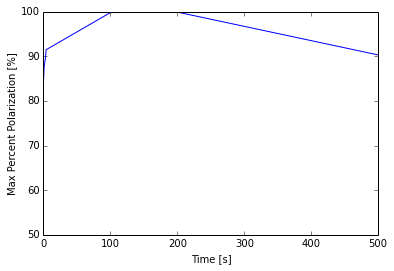

In [38]:
fifty = []
t_list = [0,1,2,3,4,100,200,499]#500,995,996,997,998,999]
#t_list = model.tspan
for i,val in enumerate(t_list):
    fifty.append(50.0)

plt.plot(t_list,percent_polarized_max_list,'b',label='Cdc42_a')
plt.plot(t_list, fifty,'r')
# plt.plot(model.tspan,percent_polarized_v_time_temp_b,'g',label='Bem1_m')
# plt.legend(loc=4)
plt.xlabel('Time [s]')
plt.ylabel('Max Percent Polarization [%]')
plt.savefig('cla4_with_cyto.pdf', format='pdf', dpi=1000)

In [39]:
numpy.array(theta_center_list)*180.0/numpy.pi

array([ 88.76553046,  84.41163422,  84.41163422,  82.9516417 ,
        84.41163422,  90.        ,  82.61495514,  72.56610946])

In [40]:
numpy.array(phi_center_list)*180.0/numpy.pi

array([ 172.18047205,  174.3848614 ,  174.3848614 ,  176.38808   ,
        174.3848614 ,  169.64039465,  169.72367978,  141.95203845])

In [41]:
#theta_center_list_2,phi_center_list_2 = percent_polarized_v_time_short_2(result)

In [42]:
#theta_center_list_2

In [43]:
#phi_center_list_2

In [44]:
#theta_center_list_3,phi_center_list_3 = percent_polarized_v_time_short_2(result)

In [45]:
#theta_center_list_3

In [46]:
#phi_center_list_3

In [47]:
#result.display("Cdc42_a",200,camera=[0, 1, 0])

In [25]:
#This currently uses the voxels listed in voxels_center (which are the top "X" percent of particle counts in B_vals) and checks
#an area around the center equivalent to roughly 10% of the membrane surface area and calculates a percentage of membrane particles
#found for each one
def percent_polarized_at_time(result, time_idx=0,species='Cdc42_a'):
    model = result.model
    
    data = model.get_solver_datastructure()
    sd = model.get_subdomain_vector()

    vol = data['vol']
    membrane_voxels = []
    for voxel_index, voxel_coords in enumerate(model.mesh.coordinates()):
        if sd[voxel_index] == 2:
            membrane_voxels.append(voxel_index)
    
    B_vals_list = []
    B_vals_to_check_list = []
    min_to_check_list = []
    voxels_center_list = []
    B_vals_sort_list = []
    #for n,t in enumerate(model.tspan):
    n = time_idx
    t = model.tspan[n]
    
    B_val_temp = result.get_species(species, timepoints=n, concentration=False)
    B_vals_list.append(B_val_temp)
    B_vals_sort_list.append(sorted(B_vals_list[n]))

    for idx,val in enumerate(B_vals_sort_list):
        B_vals_to_check_list.append(B_vals_sort_list[idx][int(len(B_vals_sort_list[idx]) * .99) : int(len(B_vals_sort_list[idx]) * 1.0)]) 
        min_to_check_list.append(min(B_vals_to_check_list[idx]))
        voxels_center_list.append(map(int,[i for i, j in enumerate(B_vals_list[idx]) if j >= min_to_check_list[idx] and sd[i] == 2])) 
    
    percent_polarized_max_list = []
    index_polarized_max_list = []
    phi_center_list = []
    theta_center_list = []
    theta_projection_xz_list =[]
    theta_projection_yz_list = []
    #for n,t in enumerate(model.tspan):
        
    B_check = sum(B_vals_list[0])
    particle_sum_list = []
    percentage_around_center_list = []
    voxel_counter_list = []
    voxels_visited_list = []
    if B_check==0:
        percentage_around_center = 0
        percentage_around_center_list.append([percentage_around_center,0.0])
    else:
        j = 0
        for v in voxels_center_list[0]:
            particle_sum = 0.0
            percentage_around_center = 0.0
            voxel_counter = 0.0
            voxels_visited = []
            x_center = model.mesh.coordinates()[v,0]
            y_center = model.mesh.coordinates()[v,1]
            z_center = model.mesh.coordinates()[v,2]
            dist_center = numpy.sqrt(x_center*x_center + y_center*y_center + z_center*z_center)
            for i in membrane_voxels: 
                x_check = model.mesh.coordinates()[i,0]
                y_check = model.mesh.coordinates()[i,1]
                z_check = model.mesh.coordinates()[i,2]
                dist_check = numpy.sqrt(x_check*x_check + y_check*y_check + z_check*z_check)
                angle_between = numpy.arccos(numpy.dot([x_center,y_center,z_center],[x_check,y_check,z_check])/(dist_check*dist_center) - 1e-8)
                if angle_between <= numpy.arcsin(.375):
                    particle_sum = particle_sum + B_vals_list[n][i]
                    voxel_counter = voxel_counter + 1
                    voxels_visited.append(i)

            particle_sum_list.append(particle_sum)
            voxel_counter_list.append(voxel_counter)
            voxels_visited_list.append([voxels_visited,v])

            percentage_around_center = particle_sum_list[j]/B_check*100 

            percentage_around_center_list.append([percentage_around_center,v])
            j = j + 1
            
        percent_polarized_max_list.append(max(percentage_around_center_list)[0])
        index_polarized_max_list.append(max(percentage_around_center_list)[1])
        x_center = model.mesh.coordinates()[index_polarized_max_list[0],0]
        y_center = model.mesh.coordinates()[index_polarized_max_list[0],1]
        z_center = model.mesh.coordinates()[index_polarized_max_list[0],2]
        dist_center = numpy.sqrt(x_center*x_center + y_center*y_center + z_center*z_center)
        dist_projection_xz = numpy.sqrt(x_center*x_center + z_center*z_center)
        dist_projection_yz = numpy.sqrt(y_center*y_center + z_center*z_center)
        theta_center_list.append(numpy.arccos(numpy.dot([x_center,y_center,z_center],[0.0,0.0,1.0])/(dist_center)-1e-8))
        theta_projection_xz_list.append(numpy.arccos(numpy.dot([x_center,y_center,z_center],[0.0,0.0,1.0])/(dist_projection_xz)-1e-8))
        theta_projection_yz_list.append(numpy.arccos(numpy.dot([x_center,y_center,z_center],[0.0,0.0,1.0])/(dist_projection_yz)-1e-8))
        #Angle between x-axis and xz projection
        phi_center_list.append(numpy.arccos(numpy.dot([x_center,0.0,z_center],[1.0,0.0,0.0])/(dist_center)-1e-8))
        
    #return [percent_polarized_max_list,numpy.mean(percent_polarized_max_list),numpy.std(percent_polarized_max_list)]
    return percent_polarized_max_list,index_polarized_max_list#,theta_center_list,phi_center_list,theta_projection_xz_list,theta_projection_yz_list

In [26]:
def connic_region_area(y1,y2,dx):
    return (y1+y2)*numpy.pi * numpy.sqrt( (y1-y2)**2 + dx**2 ) 

In [27]:
def polarization_s_profile_new(result, index_max=None, first_step=False, num_bins=51,s_max=2.0*numpy.pi,time_pt=None):
    #sys.stdout.write('polarization_s_profile\n\n')
    #print 'polarization_s_profile 1'

    
    #origin =  numpy.array([0,0,0])
    #max_vec = result.model.mesh.coordinates()[index_max,:]-origin
    if first_step:
        origin =  numpy.array([0,0,0])
        max_vec = result.model.mesh.coordinates()[index_max,:]-origin
    else:
        #ORIG
#         origin = numpy.array([1,0,0])
#         max_vec =  numpy.array([0.0,0.0,0.0])-origin
        #NEW
        origin =  numpy.array([0,0,0])
        max_vec = numpy.array([-4,0,0]) #Have max_vec be -cell_radius?
            
    B_vals_list = result.get_species('Cdc42_a', concentration=False)

    sd = result.model.get_subdomain_vector()
    radial_dist_cutoff = []
    for voxel_index, voxel_coords in enumerate(result.model.mesh.coordinates()):
        if sd[voxel_index] == 2:
            voxel_vec = (voxel_coords-origin)
            cross_vec = numpy.cross(max_vec,voxel_vec)
            x_tilde = numpy.dot(voxel_vec,max_vec)/numpy.linalg.norm(max_vec)
            if numpy.linalg.norm(cross_vec) == 0:
                y_tilde = 0
            else:
                normal_vec = numpy.cross(max_vec,cross_vec)
                y_tilde = numpy.abs(numpy.dot(normal_vec,voxel_vec))/numpy.linalg.norm(normal_vec)
            if first_step:
                radial_dist_cutoff.append([x_tilde, y_tilde, numpy.mean(B_vals_list[-200:,voxel_index])])
            else:
                if time_pt is None:
                    radial_dist_cutoff.append([x_tilde, y_tilde, numpy.mean(B_vals_list[:,voxel_index])])
                else:
                    radial_dist_cutoff.append([x_tilde, y_tilde, numpy.mean(B_vals_list[time_pt,voxel_index])])
            #
    radial_dist_cutoff = numpy.array(radial_dist_cutoff)
    
    #plt.plot(radial_dist_cutoff[:,0], radial_dist_cutoff[:,1],'.')
    #plt.title('polarization_s_profile')
    #plt.show()
    
    radial_dist_cutoff_sort = radial_dist_cutoff[radial_dist_cutoff[:,0].argsort()[::-1]]
    mutual_dist_cutoff = numpy.zeros(len(radial_dist_cutoff_sort[:,1]))
    #mutual_dist_cutoff[0] = numpy.sqrt((radial_dist_cutoff_sort[0,0])**2 + radial_dist_cutoff_sort[0,1]**2)
    mutual_dist_cutoff[0] = 0.0
    for i in range(len(mutual_dist_cutoff)-1):
        mutual_dist_cutoff[i+1] = numpy.sqrt((radial_dist_cutoff_sort[i+1,0]-radial_dist_cutoff_sort[i,0])**2 + (radial_dist_cutoff_sort[i+1,1]-radial_dist_cutoff_sort[i,1])**2)
    s_vec_cutoff = numpy.cumsum(mutual_dist_cutoff)
    
    #bin_width = s_vec_cutoff[-1]/num_bins
    bin_width = s_max/num_bins
    hist_output_min = [None for _ in range(num_bins)]
    hist_output_max = [None for _ in range(num_bins)]
    #sys.stderr.write('bin_width={0} num_bins={1} s_max+bin_width={2} s_max={3}\n'.format(bin_width,num_bins,s_max+bin_width,s_max))
    #sys.stderr.write('len(hist_output_min)={0} len(hist_output_max)={1}\n'.format(len(hist_output_min),len(hist_output_max)))
    
    
    hist_output_y = numpy.zeros((num_bins))
    hist_output_cnt = numpy.zeros((num_bins),dtype=int)
    hist_output_x = numpy.linspace(0, s_max, num_bins)
    for jndx,j in enumerate(s_vec_cutoff):
        #sys.stderr.write('jndx={0} j={1} int(j/bin_width)={2}\n'.format(jndx,j,int(j/bin_width)))
        #sys.stderr.flush()
        if j <= s_max:
            #hist_output_y[int(j/bin_width)-1] += radial_dist_cutoff_sort[jndx,2] #Bval of that point 
            if hist_output_min[int(j/bin_width)] is None or hist_output_min[int(j/bin_width)][0] < j:
                hist_output_min[int(j/bin_width)] = [j, radial_dist_cutoff_sort[jndx,0], radial_dist_cutoff_sort[jndx,1]]
            if hist_output_max[int(j/bin_width)] is None or hist_output_max[int(j/bin_width)][0] > j:
                hist_output_max[int(j/bin_width)] = [j, radial_dist_cutoff_sort[jndx,0], radial_dist_cutoff_sort[jndx,1]]
            hist_output_y[int(j/bin_width)] += radial_dist_cutoff_sort[jndx,2] #Bval of that point 
            hist_output_cnt[int(j/bin_width)] += 1 #Bval of that point 
    # find bin boundary x,y positions
    bin_x_pos = numpy.zeros(num_bins+1)
    bin_y_pos = numpy.zeros(num_bins+1)
    bin_x_pos[0] = 0
    bin_y_pos[0] = 0
    #sys.stderr.write('hist_output_min={0}\n'.format(hist_output_min))
    #sys.stderr.write('hist_output_max={0}\n'.format(hist_output_max))
    s_val_list = []
    x_val_list = []
    y_val_list = []
    for ndx in range(1,num_bins):
        if ndx>0 and hist_output_max[ndx-1] is not None:
            s_val_list.append(hist_output_max[ndx-1][0]) 
            x_val_list.append(hist_output_max[ndx-1][1]) 
            y_val_list.append(hist_output_max[ndx-1][2]) 
        if hist_output_max[ndx] is not None:
            s_val_list.append(hist_output_min[ndx][0])
            x_val_list.append(hist_output_min[ndx][1])
            y_val_list.append(hist_output_min[ndx][2])
    for ndx in range(1,num_bins+1):
        #sys.stderr.write('ndx={0}\n'.format(ndx))
        #sys.stderr.flush()
        s_val = bin_width*ndx
        # [s,x,y]
        bin_x_pos[ndx] = numpy.interp(s_val,s_val_list,x_val_list)
        bin_y_pos[ndx] = numpy.interp(s_val,s_val_list,y_val_list)
    # normalize by surface area of Truncated Connic Section
    for ndx in range(len(hist_output_y)):
        hist_output_y[ndx] = float(hist_output_y[ndx])/connic_region_area(bin_y_pos[ndx],bin_y_pos[ndx+1],bin_x_pos[ndx]-bin_x_pos[ndx+1])
            

    return radial_dist_cutoff_sort, s_vec_cutoff, hist_output_x, hist_output_y

In [43]:
tpt=700

In [44]:
radial_dist_cutoff_sort, s_vec_cutoff, hist_output_x, hist_output_y = polarization_s_profile_new(result,time_pt=tpt)

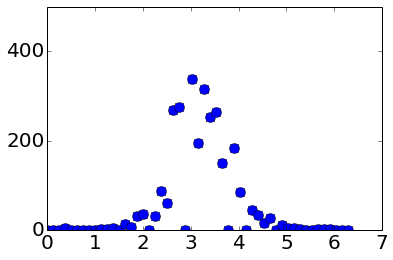

In [45]:
plt.plot(hist_output_x,hist_output_y,'o',markersize=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
x_plot = numpy.linspace(0,6,100)
plt.yticks([0,200,400])
plt.ylim([0,500])
#plt.plot(x_plot,max(hist_output_y)*numpy.exp(-x_plot**2))
plt.savefig('./pill_figs/Cdc42_{0}.png'.format(tpt),transparent=True,dpi=500)

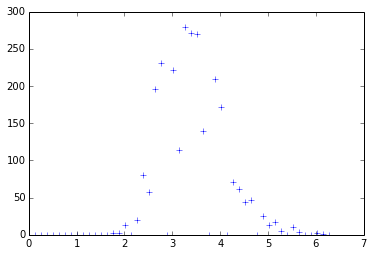

In [54]:
#path = os.path.dirname(os.path.abspath(__file__)
#t_list = [0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,999]
#t_list = numpy.linspace(0,999,num=50)
t_list = [0,1,2,3,4,100,200,899]
#t_list = [0,50,100,200,500,999]
for n,i in enumerate(t_list):
    radial_dist_cutoff_sort, s_vec_cutoff, hist_output_x, hist_output_y = polarization_s_profile_new(result,time_pt=i)
    plt.clf()
    plt.plot(hist_output_x,hist_output_y,'+')
    num_string = '{0:0=3d}'.format(n)
    plt.savefig('./shifting_fig/figure{0}.jpg'.format(num_string),dpi=500)

In [55]:
#path = os.path.dirname(os.path.abspath(__file__))

In [56]:
#result.display('Cdc42_a',999,camera=[0,-0.5,0.5])

In [57]:
test_a = [1,2,3]
test_a[::-1]

[3, 2, 1]

In [58]:
[hist_output_x[::-1],hist_output_x]

[array([ 6.28318531,  6.1575216 ,  6.03185789,  5.90619419,  5.78053048,
         5.65486678,  5.52920307,  5.40353936,  5.27787566,  5.15221195,
         5.02654825,  4.90088454,  4.77522083,  4.64955713,  4.52389342,
         4.39822972,  4.27256601,  4.1469023 ,  4.0212386 ,  3.89557489,
         3.76991118,  3.64424748,  3.51858377,  3.39292007,  3.26725636,
         3.14159265,  3.01592895,  2.89026524,  2.76460154,  2.63893783,
         2.51327412,  2.38761042,  2.26194671,  2.136283  ,  2.0106193 ,
         1.88495559,  1.75929189,  1.63362818,  1.50796447,  1.38230077,
         1.25663706,  1.13097336,  1.00530965,  0.87964594,  0.75398224,
         0.62831853,  0.50265482,  0.37699112,  0.25132741,  0.12566371,  0.        ]),
 array([ 0.        ,  0.12566371,  0.25132741,  0.37699112,  0.50265482,
         0.62831853,  0.75398224,  0.87964594,  1.00530965,  1.13097336,
         1.25663706,  1.38230077,  1.50796447,  1.63362818,  1.75929189,
         1.88495559,  2.0106193 ,  2

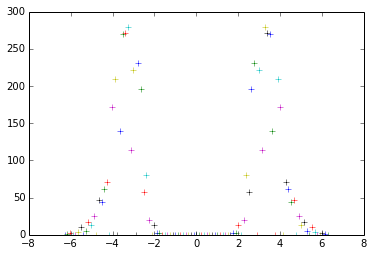

In [59]:
plt.plot([-hist_output_x[::-1],hist_output_x],[hist_output_y[::-1],hist_output_y],'+')

In [60]:
import collections
def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, basestring):
            for sub in flatten(el):
                yield sub
        else:
            yield el

[  1.47662101e+02   1.60154658e-04  -4.08841955e+00]


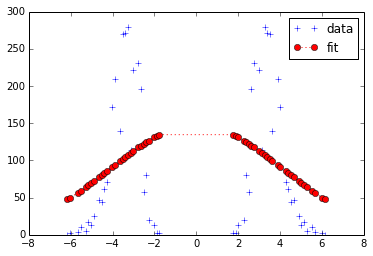

In [61]:
from scipy.optimize import curve_fit

x = numpy.array(list(flatten([-hist_output_x[::-1],hist_output_x])))
y = numpy.array(list(flatten([hist_output_y[::-1],hist_output_y])))
x = x[numpy.where(y>0)]
y = y[numpy.where(y>0)]
y[0] = 0.0
y[-1] = 0.0

n = len(x)                          #the number of data
mean = 0.0#sum(x*y)/n                   #note this correction
sigma = 2.0#sum(y*(x-mean)**2)/n        #note this correction

def gaus(x,a,x0,sigma):
    return a*numpy.exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

print popt

plt.plot(x,y,'b+',label='data')
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()

In [62]:
#FWHM of Gaussian 2.355*sigma
lamda = abs(2.355*popt[2])
lamda/2

4.8141140187921652

In [63]:
# _,index_polarized_max_list = percent_polarized_at_time(result,time_idx=-1)
# max_vec_ndx = index_polarized_max_list[0]
# print 'MAX_VEC_NDX: {0}'.format(max_vec_ndx)
# max_vec = result.model.mesh.get_voxels()[max_vec_ndx]
# print result.model.mesh.get_voxels()

In [64]:
class Cdc42_cycle_3D_rotate(pyurdme.URDMEModel):

    def __init__(self, model_name="Cdc42_3D-Moving_Mesh",Gbg_conc=5000.0,result='None',cell_radius=2.0, Gbg_pct_slope=0.0,delta1_val=0.00297,delta1_gbg_val=0.00297,delta_neg_val=1.0/30000, end_time=None, mesh=None, msh_filename=None,mesh_id=None,rotate=None):
        pyurdme.URDMEModel.__init__(self,model_name)

        D_membrane = 0.0053   #diffusion on the membrane from PLOS paper
        D_GDP = 0.0053
        D_GTP = 0.0053
        D_bulk = 50.0          #not sure of bulk diffusion const
        
        # Species
        Cdc24_m= pyurdme.Species(name="Cdc24_m",  diffusion_constant=D_membrane)
        Cdc24_c= pyurdme.Species(name="Cdc24_c",  diffusion_constant=D_bulk)
        Cdc42= pyurdme.Species(name="Cdc42",  diffusion_constant=D_GDP)
        Cdc42_a= pyurdme.Species(name="Cdc42_a",  diffusion_constant=D_GTP)
        Bem1_m = pyurdme.Species(name="Bem1_m",  diffusion_constant=D_membrane)
        Bem1_c = pyurdme.Species(name="Bem1_c",  diffusion_constant=D_bulk)
        Cla4 = pyurdme.Species(name="Cla4",  diffusion_constant=D_bulk)
        Cla4_a = pyurdme.Species(name="Cla4_a",  diffusion_constant=D_membrane)
        
        Cdc42_c = pyurdme.Species(name="Cdc42_c",  diffusion_constant=D_bulk)
        #Gbg = pyurdme.Species(name="Gbg",  diffusion_constant=D_membrane)
        self.add_species([Cdc24_m, Cdc24_c, Cdc42, Cdc42_a, Bem1_m, Bem1_c, Cla4, Cla4_a, Cdc42_c])#,Gbg])
        
#         L = 4*3.14159
#         NUM_VOXEL = 200
#         MOLAR=6.02e-01*((L/NUM_VOXEL)**3)
        #Define Geometry
        
#         if mesh is not None:
#             self.mesh = pyurdme.URDMEMesh(mesh=mesh)
#             self.add_subdomain(Membrane(), 2)
#         elif msh_filename is not None:
#             self.mesh = pyurdme.URDMEMesh.read_mesh(msh_filename)
#             boundary_filename = msh_filename[:-4]+'_facet_region.xml'
#             boundaries = dolfin.MeshFunction("size_t", self.mesh, boundary_filename)
#             self.old_style_subdomain=True
#             for i in range(boundaries.size()):
#                 if boundaries[i] != 0:  boundaries[i]=2
#             self.subdomains = collections.OrderedDict()
#             self.subdomains[2] = boundaries
#             #sd = model.get_subdomain_vector()
#         else:
#             sphere = mshr.Sphere(dolfin.Point(0.0, 0.0, 0.0), cell_radius)
#             self.mesh = pyurdme.URDMEMesh(mesh=mshr.generate_mesh(sphere, 15)) #12 works pretty similar, question of correction like in polarisome
#             self.add_subdomain(Membrane(), 2)
        if mesh_id == 'sphere_gen':
            sphere = mshr.Sphere(dolfin.Point(0.0, 0.0, 0.0), cell_radius)
            self.mesh = pyurdme.URDMEMesh(mesh=mshr.generate_mesh(sphere, 15))
            
            cell_function = dolfin.CellFunction("size_t",self.mesh)
            cell_function.set_all(1)

            facet_function = dolfin.FacetFunction("size_t",self.mesh)
            facet_function.set_all(0)

            membrane = Membrane()
            membrane.mark(facet_function,2)

            self.add_subdomain(cell_function)
            self.add_subdomain(facet_function)
        elif mesh_id == 'sphere':
            #USE RESULT SPHERE
            #self.set_initial_condition_from_result_different_mesh(sphere_result)
            self.mesh = result.model.mesh
            #self.add_subdomain(Membrane(), 2)
#             sphere = mshr.Sphere(dolfin.Point(cell_radius, 0.0, 0.0), cell_radius)
#             if cell_radius == 1.0:
#                 self.mesh = pyurdme.URDMEMesh(mesh=mshr.generate_mesh(sphere, 8))
#             elif cell_radius == 2.0:
#                 self.mesh = pyurdme.URDMEMesh(mesh=mshr.generate_mesh(sphere, 15))
#             elif cell_radius == 4.0:
#                 self.mesh = pyurdme.URDMEMesh(mesh=mshr.generate_mesh(sphere, 30))
            
            cell_function = dolfin.CellFunction("size_t",self.mesh)
            cell_function.set_all(1)

            facet_function = dolfin.FacetFunction("size_t",self.mesh)
            facet_function.set_all(0)

            membrane = Membrane()
            membrane.mark(facet_function,2)

            self.add_subdomain(cell_function)
            self.add_subdomain(facet_function)
        elif mesh_id == 'slight_deform':
            #self.set_initial_condition_from_result_different_mesh(slight_deform_result)
            self.mesh = slight_deform_result.model.mesh
            self.add_subdomain(Membrane(), 2)
        elif mesh_id == 'projection':
            #self.set_initial_condition_from_result_different_mesh(projection_result)
            self.mesh = projection_result.model.mesh
            self.add_subdomain(Membrane(), 2)
        elif mesh_id == 'proj_geo_test':
            self.mesh = proj_geo_test_result.model.mesh
            self.add_subdomain(Membrane(), 2)
        elif mesh_id == 'projection_longer':
            #self.set_initial_condition_from_result_different_mesh(projection_result)
            self.mesh = projection_longer_result.model.mesh
            self.add_subdomain(Membrane(), 2) 
        elif msh_filename is not None:
            self.mesh = pyurdme.URDMEMesh.read_mesh(msh_filename)
            boundary_filename = msh_filename[:-4]+'_facet_region.xml'
            boundaries = dolfin.MeshFunction("size_t", self.mesh, boundary_filename)
            self.old_style_subdomain=True
            for i in range(boundaries.size()):
                if boundaries[i] != 0:  boundaries[i]=2
            self.subdomains = collections.OrderedDict()
            self.subdomains[2] = boundaries
            #sd = model.get_subdomain_vector()
        else:
            raise Exception('Did not set mesh properly {0}'.format(mesh_id))
        
#         if mesh_id is 'sphere':
#             fname = '/stochss-master/app/lib/molnsutil/sphere_result.pkl'
#             with open(fname, 'r') as fd:
#                 sphere_result = pickle.load(fd)
            
#             mesh = sphere_result.model.mesh
#             self.mesh = pyurdme.URDMEMesh(mesh=mesh)
#             self.add_subdomain(Membrane(), 2)
#         elif mesh_id is 'slight_deform':
#             fname = '/stochss-master/app/lib/molnsutil/slight_deform_result.pkl'
#             with open(fname, 'r') as fd:
#                 slight_deform_result = pickle.load(fd)
#             mesh = slight_deform_result.model.mesh
#             self.mesh = pyurdme.URDMEMesh(mesh=mesh)
#             self.add_subdomain(Membrane(), 2)
#         elif mesh_id is 'projection':
#             fname = '/stochss-master/app/lib/molnsutil/projection_result.pkl'
#             with open(fname, 'r') as fd:
#                 projection_result = pickle.load(fd)
#             mesh = projection_result.model.mesh
#             self.mesh = pyurdme.URDMEMesh(mesh=mesh)
#             self.add_subdomain(Membrane(), 2)
        

#         cell_function = dolfin.CellFunction("size_t",self.mesh)
#         cell_function.set_all(1)

#         facet_function = dolfin.FacetFunction("size_t",self.mesh)
#         facet_function.set_all(0)

#         membrane = Membrane()
#         membrane.mark(facet_function,2)

#         self.add_subdomain(cell_function)
#         self.add_subdomain(facet_function)
        
        data = self.get_solver_datastructure()
        sd = self.get_subdomain_vector()
        
        #cell_radius = max(self.mesh.coordinates()[:,0])
        
        print "# voxels in SD 1 (cytoplasm)",sum(data['sd']==1)
        print "# voxels in SD 2 (membrane)",sum(data['sd']==2)
        
        #sys.stdout.write('sd={0}\n'.format(sd))
        #sys.stdout.flush()
        volume_vector = data['vol']
        
        membrane_volume = 0
        for voxel_index, voxel_coords in enumerate(self.mesh.coordinates()):
                if sd[voxel_index] == 2:
                    membrane_volume = membrane_volume + volume_vector[voxel_index]
                    
        cytoplasm_volume = 0
        for voxel_index, voxel_coords in enumerate(self.mesh.coordinates()):
                if sd[voxel_index] == 1:
                    cytoplasm_volume = cytoplasm_volume + volume_vector[voxel_index]
        
#         SA    = pyurdme.Parameter(name="SA" ,expression=50.265)
#         V     = pyurdme.Parameter(name="V" ,expression=33.5)
        k_42d =   pyurdme.Parameter(name="k_42d", expression=1.0)#0.02)
        k_42a =   pyurdme.Parameter(name="k_42a", expression=0.2)#ORIGINAL: 0.2 #INCREASE: 0.2*100.0 #1e-05*membrane_volume)#*SA)
        #k_24cm0 = pyurdme.Parameter(name="k_24cm0", expression=0.04*cytoplasm_volume)#*V/SA)
        k_24cm1 = pyurdme.Parameter(name="k_24cm1", expression=delta1_val)#ORIGINAL: delta1_val #3.3e-03*cytoplasm_volume)#*V)
        k_24mc =  pyurdme.Parameter(name="k_24mc", expression=0.35) #ORIGINAL: 0.35 #1.0)
        k_B1mc =  pyurdme.Parameter(name="k_B1mc", expression=0.35)#0.01)
        k_B1cm =  pyurdme.Parameter(name="k_B1cm", expression=0.2667)#ORIGINAL: 0.2667 #1e-05*cytoplasm_volume)#*V)
        k_Cla4a = pyurdme.Parameter(name="k_Cla4a", expression=0.006)
        k_Cla4d = pyurdme.Parameter(name="k_Cla4d", expression=0.01)
        k_24d =   pyurdme.Parameter(name="k_24d", expression=delta_neg_val)#1/3000#membrane_volume#SA
        
        beta1 = pyurdme.Parameter(name="beta1", expression=0.266) #ORIGINAL: 0.266  #INCREASE: 0.266*100.0
        beta2 = pyurdme.Parameter(name="beta2", expression=0.28)
        beta3 = pyurdme.Parameter(name="beta3", expression=1.0) #*10.0 #ORIGINAL: 1.0 #INCREASE: 1.0*10.0
        delta1_gbg = pyurdme.Parameter(name="delta1_gbg", expression=delta1_gbg_val)
        self.add_parameter([k_42a, k_42d, k_24cm1, k_24mc, k_B1mc, k_B1cm, k_Cla4a, k_Cla4d, k_24d,beta1, beta2, beta3,delta1_gbg])

        # Add Data Function to model the mating pheromone gradient.
        #self.add_data_function(GbgGradient(Gbg_mid=Gbg_conc,Gbg_slope=(1000.0/4.0),mem_vol=membrane_volume))
        self.add_data_function(GbgGradient(Gbg_mid=Gbg_conc,Gbg_slope=Gbg_conc*Gbg_pct_slope/(cell_radius*2.0),mem_vol=membrane_volume))

        # Reactions
        # Reactions
        #Gbg as species
        #CR0 = pyurdme.Reaction(name="CR0", reactants={Cdc24_c:1,Gbg:1}, products={Cdc24_m:1,Gbg:1}, rate=delta1,restrict_to=2)#propensity_function="0.00297*Cdc24_c*GbgGradient*vol", restrict_to=2)
        #Gbg as input function
        #DIFFERENCE WHETHER TO MULTIPLY BY 32 OR NOT
        CR0 = pyurdme.Reaction(name="CR0", reactants={Cdc24_c:1}, products={Cdc24_m:1}, propensity_function="delta1_gbg*Cdc24_c*GbgGradient*vol", restrict_to=2)
        CR1 = pyurdme.Reaction(name="CR1", reactants={Cdc24_c:1,Bem1_m:1}, products={Cdc24_m:1,Bem1_m:1},  rate=k_24cm1, restrict_to=2)
        CR2 = pyurdme.Reaction(name="CR2", reactants={Cdc24_m:1}, products={Cdc24_c:1}, rate=k_24mc, restrict_to=2)
        CR3 = pyurdme.Reaction(name="CR3", reactants={Cdc24_m:1,Cla4_a:1}, products={Cdc24_c:1,Cla4_a:1}, rate=k_24d, restrict_to=2)
        CR4 = pyurdme.Reaction(name="CR4", reactants={Cdc24_m:1,Cdc42:1}, products={Cdc24_m:1,Cdc42_a:1}, rate=k_42a, restrict_to=2)
        CR5 = pyurdme.Reaction(name="CR5", reactants={Cdc42_a:1}, products={Cdc42:1}, rate=k_42d, restrict_to=2)
        CR6 = pyurdme.Reaction(name="CR6", reactants={Cdc42_a:1,Bem1_c:1}, products={Cdc42_a:1,Bem1_m:1}, rate=k_B1cm, restrict_to=2)
        CR7 = pyurdme.Reaction(name="CR7", reactants={Bem1_m:1}, products={Bem1_c:1}, rate=k_B1mc, restrict_to=2)
        CR8 = pyurdme.Reaction(name="CR8", reactants={Cdc42_a:1,Cla4:1}, products={Cdc42_a:1,Cla4_a:1}, rate=k_Cla4a, restrict_to=2)
        CR9 = pyurdme.Reaction(name="CR9", reactants={Cla4_a:1}, products={Cla4:1}, rate=k_Cla4d, restrict_to=2)
        
        CR10 = pyurdme.Reaction(name="CR10", reactants={Cdc42_c:1}, products={Cdc42:1}, rate=beta2, restrict_to=2)
        CR11 = pyurdme.Reaction(name="CR11", reactants={Cdc42:1}, products={Cdc42_c:1}, rate=beta3, restrict_to=2)
        CR12 = pyurdme.Reaction(name="CR12", reactants={Cdc42_c:1,Cdc24_m:1}, products={Cdc42_a:1,Cdc24_m:1}, rate=beta1, restrict_to=2)
        self.add_reaction([CR0,CR1,CR2,CR3,CR4,CR5,CR6,CR7,CR8,CR9,CR10,CR11,CR12])
        #self.add_reaction([CR0,CR1,CR2,CR3,CR4,CR5,CR6,CR7,CR8,CR9])
        
        self.restrict(species=Cdc24_c,subdomains=[1,2])
        self.restrict(species=Bem1_c,subdomains=[1,2])
        self.restrict(species=Cla4,subdomains=[1,2])
        self.restrict(species=Cdc24_m,subdomains=[2])
        self.restrict(species=Cdc42,subdomains=[2])
        self.restrict(species=Cdc42_a,subdomains=[2])
        self.restrict(species=Bem1_m,subdomains=[2])
        self.restrict(species=Cla4_a,subdomains=[2])
        self.restrict(species=Cdc42_c,subdomains=[1,2])
        #self.restrict(species=Gbg,subdomains=[2])
        
        
        #SCATTER IC
#         try:
            # Distribute molecules randomly over the mesh according to their initial values
#         self.set_initial_condition_scatter({Cdc42:2700},[2]) #10000  
#         self.set_initial_condition_scatter({Cdc24_c:1000},[1])    #We have 2000 Cdc24, GDI model has 1000
#         self.set_initial_condition_scatter({Bem1_c:3000},[1])
#         self.set_initial_condition_scatter({Cla4:5000},[1]) #5000
#         #self.set_initial_condition_scatter({Cdc42_c:1500},[1])
#         self.set_initial_condition_scatter({Cdc42_a:300},[2])
#         #self.set_initial_condition_scatter({Gbg:5000},[2])
        
        #IC FROM DIFFERENT MESH
        _,index_polarized_max_list = percent_polarized_at_time(result,time_idx=-1)
        max_vec_ndx = index_polarized_max_list[0]
        print 'MAX_VEC_NDX: {0}'.format(max_vec_ndx)
        max_vec = result.model.mesh.get_voxels()[max_vec_ndx]
        print result.model.mesh.get_voxels()
        print 'MAX_VEC: {0}'.format(max_vec)
        self.set_initial_condition_from_result_different_mesh(result,o_orig=[0,0,0], o_vec=max_vec, d_orig=[0,0,0], d_vec=[-cell_radius,0,0],verbose='True')
        
#         if mesh_id == 'sphere':
#             self.set_initial_condition_from_result_different_mesh(sphere_result)#,o_orig=[0,0,0], o_vec=[1,0,0], rotate_rad=numpy.pi)
# #             self.set_initial_condition_scatter({Cdc42:2700},[2]) #10000  
# #             self.set_initial_condition_scatter({Cdc24_c:1000},[1])    #We have 2000 Cdc24, GDI model has 1000
# #             self.set_initial_condition_scatter({Bem1_c:3000},[1])
# #             self.set_initial_condition_scatter({Cla4:5000},[1]) #5000
# #             #self.set_initial_condition_scatter({Cdc42_c:1500},[1])
# #             self.set_initial_condition_scatter({Cdc42_a:300},[2])
# #             #self.set_initial_condition_scatter({Gbg:5000},[2])
#         elif mesh_id == 'slight_deform':
#             self.set_initial_condition_from_result_different_mesh(slight_deform_result)#,o_orig=[0,0,0], o_vec=[1,0,0], rotate_rad=numpy.pi)
# #             self.set_initial_condition_scatter({Cdc42:2956},[2]) #10000  
# #             self.set_initial_condition_scatter({Cdc24_c:1095},[1])    #We have 2000 Cdc24, GDI model has 1000
# #             self.set_initial_condition_scatter({Bem1_c:3284},[1])
# #             self.set_initial_condition_scatter({Cla4:5474},[1]) #5000
# #             #self.set_initial_condition_scatter({Cdc42_c:1500},[1])
# #             self.set_initial_condition_scatter({Cdc42_a:328},[2])
# #             #self.set_initial_condition_scatter({Gbg:5000},[2])
#         elif mesh_id == 'projection':
#             self.set_initial_condition_from_result_different_mesh(projection_result)#,o_orig=[0,0,0], o_vec=[1,0,0], rotate_rad=numpy.pi)
# #             self.set_initial_condition_scatter({Cdc42:3144},[2]) #10000  
# #             self.set_initial_condition_scatter({Cdc24_c:1164},[1])    #We have 2000 Cdc24, GDI model has 1000
# #             self.set_initial_condition_scatter({Bem1_c:3493},[1])
# #             self.set_initial_condition_scatter({Cla4:5822},[1]) #5000
# #             #self.set_initial_condition_scatter({Cdc42_c:1500},[1])
# #             self.set_initial_condition_scatter({Cdc42_a:349},[2])
# #             #self.set_initial_condition_scatter({Gbg:5000},[2])
#         elif mesh_id == 'projection_longer':
#             self.set_initial_condition_from_result_different_mesh(projection_longer_result)#,o_orig=[0,0,0], o_vec=[1,0,0], rotate_rad=numpy.pi)
# #             self.set_initial_condition_scatter({Cdc42:3288},[2]) #10000  
# #             self.set_initial_condition_scatter({Cdc24_c:1218},[1])    #We have 2000 Cdc24, GDI model has 1000
# #             self.set_initial_condition_scatter({Bem1_c:3653},[1])
# #             self.set_initial_condition_scatter({Cla4:6088},[1]) #5000
# #             #self.set_initial_condition_scatter({Cdc42_c:1500},[1])
# #             self.set_initial_condition_scatter({Cdc42_a:365},[2])
# #             #self.set_initial_condition_scatter({Gbg:5000},[2])
        
        
#         except Exception as e:
#             sys.stderr.write("caught exception: {0}".format(e))
#         fname = '/stochss-master/app/lib/molnsutil/sphere_result.pkl'
#         with open(fname, 'r') as fd:
#             sphere_result = pickle.load(fd)
#         self.set_initial_condition_from_result_different_mesh(sphere_result)
#         if mesh_id == 'sphere':
#             #self.set_initial_condition_from_result_different_mesh(sphere_result)
            
#             if rotate is None:
#                 #IC FROM COUPLING
#                 self.set_initial_condition_from_result_different_mesh(sphere_result)            
#             else:
#                 #rotate IC
#                 self.set_initial_condition_from_result_different_mesh(sphere_result, o_orig=[0,0,0], o_vec=[0,0,1], rotate_rad=rotate,verbose=True)
#         elif mesh_id == 'slight_deform':
#             self.set_initial_condition_from_result_different_mesh(slight_deform_result)
#         elif mesh_id == 'projection':
#             #SCATTER
# #             self.set_initial_condition_scatter({Cdc42:2700},[2]) #10000  
# #             self.set_initial_condition_scatter({Cdc24_c:1000},[1])    #We have 2000 Cdc24, GDI model has 1000
# #             self.set_initial_condition_scatter({Bem1_c:3000},[1])
# #             self.set_initial_condition_scatter({Cla4:5000},[1]) #5000
# #             #self.set_initial_condition_scatter({Cdc42_c:1500},[1])
# #             self.set_initial_condition_scatter({Cdc42_a:300},[2])
# #             #self.set_initial_condition_scatter({Gbg:5000},[2])
            
#             if rotate is None:
#                 #IC FROM COUPLING
#                 self.set_initial_condition_from_result_different_mesh(projection_result)            
#             else:
#                 #rotate IC
#                 self.set_initial_condition_from_result_different_mesh(projection_result, o_orig=[0,0,0], o_vec=[0,0,1], rotate_rad=rotate)
#         elif mesh_id == 'proj_geo_test':
#             self.set_initial_condition_from_result_different_mesh(proj_geo_test_result)
#         elif mesh_id == 'projection_longer':
#             self.set_initial_condition_from_result_different_mesh(projection_longer_result)
        
        
        if end_time is None:
            self.timespan(range(1000))
        else:
            #self.timespan([0, end_time])
            if end_time >= 1.0:
                self.timespan(range(end_time))
            else:
                self.timespan(numpy.linspace(0,end_time,10))
            print "simulating to {0}s".format(end_time)

In [65]:
?pyurdme.URDMEModel.set_initial_condition_from_result_different_mesh

In [66]:
model_rotate = Cdc42_cycle_3D_rotate(delta_neg_val=0.0/30000,cell_radius=4.0,mesh_id = 'sphere',end_time=100,result=result)

# voxels in SD 1 (cytoplasm) 893
# voxels in SD 2 (membrane) 1094
MAX_VEC_NDX: 762

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:66: RuntimeWarning: invalid value encountered in double_scalars
set_initial_condition_from_result_different_mesh() doing vector transformation
TT=[[-0.90527272 -0.37852722 -0.19286897]
 [ 0.37852722 -0.51258289 -0.77069834]
 [ 0.19286897 -0.77069834  0.60731016]] tr=[0 0 0]
Transfering species 'Cdc24_m' as 'Cdc24_m'
Transfering species 'Cdc24_c' as 'Cdc24_c'
Transfering species 'Cdc42' as 'Cdc42'
Transfering species 'Cdc42_a' as 'Cdc42_a'
Transfering species 'Bem1_m' as 'Bem1_m'
Transfering species 'Bem1_c' as 'Bem1_c'
Transfering species 'Cla4' as 'Cla4'
Transfering species 'Cla4_a' as 'Cla4_a'



[[ 0.          0.          0.        ]
 [ 0.0197451   0.173031    0.        ]
 [ 0.0197451   0.164563    0.0534696 ]
 ..., 
 [ 1.96761647  0.73223162 -0.38601954]
 [ 4.43566593 -1.26164189  1.086178  ]
 [ 5.59647015 -0.66176116 -0.56954463]]
MAX_VEC: [ 2.823895    1.1807725   0.60163275]
simulating to 100s


Transfering species 'Cdc42_c' as 'Cdc42_c'


In [67]:
result_rotate = model_rotate.run()

In [68]:
#result_rotate.display('Cdc42_a',-1,camera=[-2,0,0])

In [69]:
#result.display('Cdc42_a',-1,camera=[-2,0,0])

In [70]:
radial_dist_cutoff_sort, s_vec_cutoff, hist_output_x, hist_output_y = polarization_s_profile_new(result_rotate,time_pt=80)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:105: RuntimeWarning: invalid value encountered in double_scalars


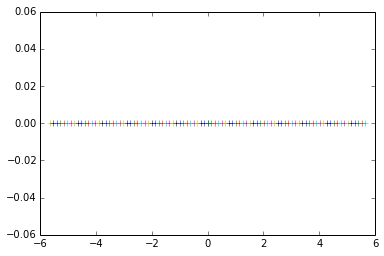

In [71]:
plt.plot([-hist_output_x[::-1],hist_output_x],[hist_output_y[::-1],hist_output_y],'+')

In [72]:
from scipy.optimize import curve_fit

x = numpy.array(list(flatten([-hist_output_x[::-1],hist_output_x])))
y = numpy.array(list(flatten([hist_output_y[::-1],hist_output_y])))
x = x[numpy.where(y>0)]
y = y[numpy.where(y>0)]
y[0] = 0.0
y[-1] = 0.0

n = len(x)                          #the number of data
mean = 0.0#sum(x*y)/n                   #note this correction
sigma = 2.0#sum(y*(x-mean)**2)/n        #note this correction

def gaus(x,a,x0,sigma):
    return a*numpy.exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

print popt

plt.plot(x,y,'b+',label='data')
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
#FWHM of Gaussian 2.355*sigma
lamda = abs(2.355*popt[2])
lamda

In [ ]:
plt.plot(hist_output_x,hist_output_y,'+')

In [ ]:
x = numpy.array(hist_output_x)
y = numpy.array(hist_output_y)
x = x[numpy.where(y>150)]
y = y[numpy.where(y>150)]
#y[0] = 0.0
#y[-1] = 0.0

n = len(x)                          #the number of data
mean = 0.0#sum(x*y)/n                   #note this correction
sigma = 2.0#sum(y*(x-mean)**2)/n        #note this correction

def gaus(x,a,sigma):
    return a*numpy.exp(-(x)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[400,sigma])

print popt

plt.plot(x,y,'b+',label='data')
#plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.plot(numpy.linspace(-4,4,num=100),gaus(numpy.linspace(-4,4,num=100),*popt),'ro:',label='fit')
plt.xlim([-6,6])
#plt.ylim([0,1500])
plt.legend()

In [ ]:
#FWHM of Gaussian 2.355*sigma
lamda = abs(2.355*popt[1])
lamda

In [ ]:
radial_dist_cutoff_sort, s_vec_cutoff, hist_output_x, hist_output_y = polarization_s_profile_new(result_rotate,time_pt=80)

In [ ]:
plt.plot(hist_output_x,hist_output_y,'+')

In [ ]:
len_vs_t = numpy.zeros(len(model_rotate.tspan))
for i,t in enumerate(model_rotate.tspan): 

    radial_dist_cutoff_sort, s_vec_cutoff, hist_output_x, hist_output_y = polarization_s_profile_new(result_rotate,time_pt=t)

    x = numpy.array(hist_output_x)
    y = numpy.array(hist_output_y)
    x = x[numpy.where(y>150)]
    y = y[numpy.where(y>150)]
    #y[0] = 0.0
    #y[-1] = 0.0

    n = len(x)                          #the number of data
    mean = 0.0#sum(x*y)/n                   #note this correction
    sigma = 2.0#sum(y*(x-mean)**2)/n        #note this correction
    
    def gaus(x,a,sigma):
        return a*numpy.exp(-(x)**2/(2*sigma**2))

    try:
        popt,pcov = curve_fit(gaus,x,y,p0=[400,sigma])

        len_vs_t[i] = 2.355*abs(popt[1])
    except:
        len_vs_t[i] = 10 

In [ ]:
numpy.mean(len_vs_t[numpy.where(len_vs_t<10)]),numpy.std(len_vs_t[numpy.where(len_vs_t<10)])

In [ ]:
# fname = './length_scale_measure/Cdc42_FWHM_r_4_2_result_rotate.pkl'
# with open(fname, 'w+') as fd:
#     pickle.dump(result_rotate, fd)

In [ ]:
# file_list = ['./length_scale_measure/Cdc42_FWHM_r_1_1.pkl',
#              './length_scale_measure/Cdc42_FWHM_r_1_2.pkl',
#              './length_scale_measure/Cdc42_FWHM_r_1_3.pkl',
#              './length_scale_measure/Cdc42_FWHM_r_1_4.pkl',
#              './length_scale_measure/Cdc42_FWHM_r_1_5.pkl',
#              './length_scale_measure/Cdc42_FWHM_r_2_1.pkl',
#              './length_scale_measure/Cdc42_FWHM_r_2_2.pkl',
#              './length_scale_measure/Cdc42_FWHM_r_2_3.pkl',
#              './length_scale_measure/Cdc42_FWHM_r_2_4.pkl',
#              './length_scale_measure/Cdc42_FWHM_r_2_5.pkl']

In [ ]:
# k=0
# fwhm_tavg = numpy.zeros(len(file_list))
# for pkl_result in file_list:
#     with open(pkl_result,'r') as fd:
#         result_rotate = pickle.load(fd)
#     model_rotate = result_rotate.model
#     len_vs_t = numpy.zeros(len(model_rotate.tspan))
#     for i,t in enumerate(model_rotate.tspan): 

#         radial_dist_cutoff_sort, s_vec_cutoff, hist_output_x, hist_output_y = polarization_s_profile_new(result_rotate,time_pt=t)

#         x = numpy.array(hist_output_x)
#         y = numpy.array(hist_output_y)
#         x = x[numpy.where(y>0)]
#         y = y[numpy.where(y>0)]
#         #y[0] = 0.0
#         y[-1] = 0.0

#         n = len(x)                          #the number of data
#         mean = 0.0#sum(x*y)/n                   #note this correction
#         sigma = 2.0#sum(y*(x-mean)**2)/n        #note this correction

#         def gaus(x,a,sigma):
#             return a*numpy.exp(-(x)**2/(2*sigma**2))

#         try:
#             popt,pcov = curve_fit(gaus,x,y,p0=[400,sigma])

#             len_vs_t[i] = 2.355*abs(popt[1])
#         except:
#             len_vs_t[i] = 10 
        
#     fwhm_tavg[k] = numpy.mean(len_vs_t)
#     k = k + 1

In [ ]:
# plt.boxplot([fwhm_tavg[0:4],fwhm_tavg[5:9]])
# plt.ylim([0,3])

In [ ]:
o_orig = [0,0,0]
o_vec = [4/numpy.sqrt(3),4/numpy.sqrt(3),4/numpy.sqrt(3)]
d_orig = [0,0,0]
d_vec = [-4,0,0]

translate_vec = numpy.array(d_orig) - numpy.array(o_orig)
v_a = numpy.array(o_vec)
v_a = v_a / numpy.linalg.norm(v_a)
v_b = numpy.array(numpy.array(d_vec) - translate_vec)
v_b = v_b / numpy.linalg.norm(v_b)
vv = numpy.cross(v_a, v_b)
s = numpy.linalg.norm(vv)
cc = numpy.dot(v_a,v_b)
v_cross = numpy.array([[0, -vv[2], vv[1]],[vv[2],0,-vv[0]],[-vv[1],vv[0],0]])
RT = numpy.eye(3) + v_cross + numpy.dot(v_cross,v_cross)*(1/(1+cc))

numpy.dot(RT,o_vec)

In [ ]:
v_b

In [ ]:
numpy.sqrt(1.20255567**2 +(-0.53258213)**2 +(-0.81306366)**2)